In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.colors
import re

from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from gower import gower_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.cluster.hierarchy import linkage , fcluster , dendrogram
from scipy.spatial.distance import pdist , squareform
from scipy.stats import pearsonr, chi2_contingency, f_oneway

os.makedirs('output', exist_ok=True)


Esta análise tem como objetivo análisar o perfil dos clientes, prever faltas e estimar o faturamento com base em diversas variáveis. Utilizamos o método CRISP-DM (Cross-Industry Standard Process for Data Mining), um padrão de processo aberto e independente de fornecedor, que proporciona um modelo estruturado para guiar projetos de data mining. O CRISP-DM consiste em seis fases:

- **Entendimento do Negócio**: Compreender os objetivos do projeto e os requisitos a partir de uma perspectiva de negócios, convertendo esse conhecimento em uma definição do problema de mineração de dados.

- **Entendimento dos Dados**: Coletar dados iniciais, familiarizar-se com eles, identificar problemas de qualidade de dados e descobrir percepções preliminares.

- **Preparação dos Dados**: Preparar o conjunto de dados final que será utilizado na fase de modelagem. Isso inclui tarefas como seleção de dados, limpeza de dados, construção de variáveis e formatação de dados.

- **Modelagem**: Selecionar e aplicar técnicas de modelagem, calibrando os parâmetros para valores ótimos. Neste projeto, utilizamos modelos de regressão linear e árvore de regressão, dentre outros.

- **Avaliação**: Avaliar o modelo para garantir que ele atinge os objetivos de negócios. Se o modelo tiver um desempenho satisfatório, ele é considerado pronto para a fase de implementação.

- **Implementação**: Implementar o modelo na prática, que pode envolver a geração de relatórios ou a integração de um sistema de suporte à decisão.

## Etapa 1 CRISP - DM: Entendimento do negócio

O projeto utiliza dados reais de atendimentos médicos realizados em 2023 e 2024, organizados em três bases de dados:

- **Base de Clientes** – Contém informações cadastrais dos pacientes, como sexo e bairro de residência.
- **Base de Produção** – Registra os atendimentos realizados, incluindo a especialidade do médico, data do atendimento, forma de pagamento e valores faturados.
- **Base de Repasse Médico** – Apresenta os valores repassados aos médicos conforme os atendimentos realizados.
Antes de carregar os dados, foi realizado um pré-tratamento para remover informações sensíveis e garantir a privacidade dos clientes, visto que este projeto será publicado.

O principal objetivo do projeto é analisar os padrões de atendimento, faturamento e repasse médico para entender melhor o comportamento dos pacientes e a produtividade dos profissionais de saúde. Além disso, busca-se desenvolver um modelo preditivo para estimar o faturamento no ano de 2025, auxiliando na tomada de decisões estratégicas para otimização de recursos.

## Etapa 2 CRISP - DM Entendimento dos dados

In [2]:
def analises(df):
    variaveis = list(df.columns)
    
    # Remove colunas indesejadas como índices, datas e identificadores
    variaveis = [var for var in variaveis if var not in ['index', 'data_ref', 'id_amigo']]
    
    # Identifica colunas do tipo data
    variaveis_data = [var for var in variaveis if np.issubdtype(df[var].dtype, np.datetime64)]
    
    # Remove colunas do tipo data da análise
    variaveis = [var for var in variaveis if var not in variaveis_data]

    # Separação entre variáveis qualitativas e quantitativas
    variaveis_quali = [var for var in variaveis if df[var].dtype == 'object']
    variaveis_quant = [var for var in variaveis if df[var].dtype != 'object']
    
    for var1 in variaveis:
        for var2 in variaveis:
            if var1 != var2:  # Evita comparar a mesma variável com ela mesma
    
                # Quantitativa x Quantitativa
                if (var1 in variaveis_quant) and (var2 in variaveis_quant):
                    corr, _ = pearsonr(df[var1], df[var2])
                    print(f'Correlação entre {var1} e {var2}: {corr:.2f}')
                    
                    # Gráfico de Dispersão
                    plt.figure(figsize=(8, 6))
                    sns.scatterplot(x=df[var1], y=df[var2])
                    plt.title(f'Dispersão entre {var1} e {var2}')
                    plt.show()
    
                # Qualitativa x Qualitativa
                elif (var1 in variaveis_quali) and (var2 in variaveis_quali):
                    tabela_contingencia = pd.crosstab(df[var1], df[var2])
                    chi2, p, _, _ = chi2_contingency(tabela_contingencia)
                    print(f'Teste Qui-Quadrado entre {var1} e {var2}: p-valor = {p:.4f}')
                    
                    # Gráfico de Barras Empilhadas
                    tabela_contingencia.plot(kind='bar', stacked=True, figsize=(6, 4))
                    plt.title(f'Relação entre {var1} e {var2}')
                    plt.xlabel(var1)
                    plt.ylabel('Frequência')
                    plt.legend(title=var2)
                    plt.xticks(rotation=45)
                    plt.show()
    
                # Qualitativa x Quantitativa
                elif (var1 in variaveis_quali and var2 in variaveis_quant) or \
                     (var2 in variaveis_quali and var1 in variaveis_quant):
    
                    # Determina qual é a categórica e qual é a numérica
                    cat_var = var1 if var1 in variaveis_quali else var2
                    num_var = var2 if var1 in variaveis_quali else var1
                    
                    # Boxplot para visualizar distribuição
                    plt.figure(figsize=(6, 4))
                    sns.boxplot(x=df[cat_var], y=df[num_var], hue=df[cat_var], palette='Set2')
                    plt.title(f'{num_var} por {cat_var}')
                    plt.xticks(rotation=45)
                    plt.show()

In [3]:
output_dir = r"..\Projeto semantix\output"
os.makedirs(output_dir, exist_ok=True)
sns.set_theme(style = 'whitegrid')

In [4]:
pacientes = pd.read_excel(r"..\Projeto semantix\input\pacientes\pacientes.xlsx")
pacientes.columns = pacientes.columns.str.lower()
produtividade = pd.read_excel(r"..\Projeto semantix\input\produtividade\produtividade 2 anos.xlsx")
produtividade.columns = produtividade.columns.str.lower()
repasse = pd.read_excel(r"..\Projeto semantix\input\repasses\repasse 23 e 24.xlsx")
repasse.columns = repasse.columns.str.lower()

### BASE DE PACIENTES

In [5]:
pacientes.head()

id amigo data de nascimento       sexo  bairro  convênio     plano  \
0  42505539         02/05/1978  Masculino     NaN  PLANSERV       NaN   
1  42505540         29/04/1954   Feminino     NaN  PLANSERV       NaN   
2  42505541         24/04/1982  Masculino     NaN       NaN       NaN   
3  42505542         02/07/1969   Feminino     NaN       NaN       NaN   
4  42505543         03/08/1972   Feminino  ITAPUÃ  PLANSERV  PLANSERV   

  data do último agendamento data do próximo agendamento data de criação  
0                        NaN                         NaN      27/09/2022  
1                        NaN                         NaN      27/09/2022  
2                        NaN                         NaN      27/09/2022  
3                        NaN                         NaN      27/09/2022  
4                        NaN                         NaN      27/09/2022

In [6]:
pacientes.tail()

id amigo data de nascimento      sexo               bairro   convênio  \
10028  82476481         18/04/1995  Feminino     Jardim Placaford        NaN   
10029  82476751         14/07/1992  Feminino  Alto do Coqueirinho  PARATODOS   
10030  82490618                NaN       NaN                  NaN        NaN   
10031  82496203                NaN       NaN                  NaN        NaN   
10032  82499241                NaN       NaN                  NaN        NaN   

      plano data do último agendamento data do próximo agendamento  \
10028   NaN           26/11/2024 12:20                         NaN   
10029   NaN           26/11/2024 07:40                         NaN   
10030   NaN                        NaN            09/12/2024 13:00   
10031   NaN                        NaN            05/12/2024 07:20   
10032   NaN                        NaN            30/11/2024 07:20   

      data de criação  
10028      25/11/2024  
10029      25/11/2024  
10030      25/11/2024  
10031      26/11/2024  
10032      26/11/2024

In [7]:
pacientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10033 entries, 0 to 10032
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id amigo                     10033 non-null  int64 
 1   data de nascimento           9272 non-null   object
 2   sexo                         8876 non-null   object
 3   bairro                       8395 non-null   object
 4   convênio                     2562 non-null   object
 5   plano                        5979 non-null   object
 6   data do último agendamento   5189 non-null   object
 7   data do próximo agendamento  22 non-null     object
 8   data de criação              10033 non-null  object
dtypes: int64(1), object(8)
memory usage: 705.6+ KB


In [8]:
pacientes['id amigo'].duplicated().sum()

0

In [9]:
pacientes.sexo.isnull().sum()

1157

In [10]:
pacientes.bairro.unique()#Valores únicos na coluna bairro

array([nan, 'ITAPUÃ', 'Lauro de Freitas', 'ITINGA', 'Stella Maris',
       'SÃO CRISTÓVÃO', 'MUSSURUNGA', 'VILAS DE ABRANTES', 'Cajazeiras',
       'JARDIM DAS MARGARIDAS', 'PIATÃ', 'ALPHAVILE 1', 'SÃO GONÇALO',
       'TANCREDO NEVES', 'BAIRRO DA PAZ', 'FAZENDA GARCIA',
       'SIMÕES FILHO', 'PARQUE SÃO CRISTÓVÃO', 'NOVA BRASILIA DE ITAPUÃ',
       'BURAQUINHO', 'Pau Miúdo', 'BOCA DO RIO', 'ALTO DO COQUEIRINHO',
       'SÃO CAETANO', 'Bairro da Paz', 'IMBUI', 'CAMAÇARI', 'AREMBEPE',
       'CABULA', 'VIDA NOVA', 'JARDIM NOVA ESPERANÇA',
       'IPITANGA LAURO DE FREITAS', 'PITUAÇU', 'praia do flamengo',
       'SÃO MARCOS', 'ESTRADA DAS BARREIRAS', 'federação', 'PAU DA LIMA',
       'SANTA TEREZINHA', 'JARDIM PLACAFORD', 'PARIPE', 'ÁGUAS CLARAS',
       'CANABRAVA', 'alto do coqueirinho', 'ENGENHO VELHO DE FEDERACAO',
       'Fazenda Grande do Retiro', 'VALÉRIA', 'SAUDE', 'bairro da paz',
       'CAJI', 'PARALELA', 'PLACAFORD', 'Itapuã', 'NOVA DIAS DAVILA',
       'COLINA DE ITAPUÃ',

In [11]:
print('Valores únicos na coluna bairro {}'.format(pacientes.bairro.nunique())) #Quantidade de valores únicos na coluna bairro
print('Valores nulos na coluna bairro {}'.format(pacientes.bairro.isnull().sum())) #Quantidade de valores nulos na coluna bairro

Valores únicos na coluna bairro 520
Valores nulos na coluna bairro 1638


In [12]:
print('Valores nulos na coluna data de nascimento {}'.format(pacientes['data de nascimento'].isnull().sum()))

Valores nulos na coluna data de nascimento 761


In [13]:
pacientes['plano'].unique()

array([nan, 'PLANSERV', 'SULAMERICA', 'Particular', 'GOLDEN CROSS',
       'PETROBRAS', 'Sul America', 'ASTEBA', 'ASSEBA', 'Asseba', 'AMS',
       'IPS', 'Unimed', 'SUL AMERICA', '312', 'GEAP', 'ams',
       'empresarial', 'cortesia', 'central nacional', 'sulamerica',
       'UNIMED', '0569116023', 'Uniplan', 'asseba', '0516738780',
       'Basico 445', '76527450559', 'especial', 'Ams', 'Classico',
       'UNIMED RIO', 'SUL AMÉRICA', 'CORTEZIA', 'UNIMED SEGUROS',
       'Especial', 'SAÚDE BRADESCO', 'unimed', 'unimed seguros',
       '10723099553005', 'CORTESIA', 'SULAMÉRICA', 'Sulamerica',
       'MEDISERVICE', '08327084534006', 'Enfermaria  MTE', 'geap',
       'medial', '010003649903', 'PROMÉDICA', 'Norte/Nordeste',
       'Curitiba', 'Central nacional', 'norte nordeste', 'MARIGA',
       'Central  Nacional', 'Norte Nordeste', 'NORTE NORDESTE', 'RIO',
       'paratodos', 'PARATODOS', 'Paratodos', 'Sul Mineira',
       'costa do descobrimento', 'cortersia', 'Bradesco Saúde', 'rio',
 

In [14]:
pacientes.convênio.unique()

array(['PLANSERV', nan, 'ASSEBA', 'ASTEBA', 'PARATODOS'], dtype=object)

In [15]:
print(pacientes.convênio.isnull().sum())
print(pacientes.plano.isnull().sum())

7471
4054


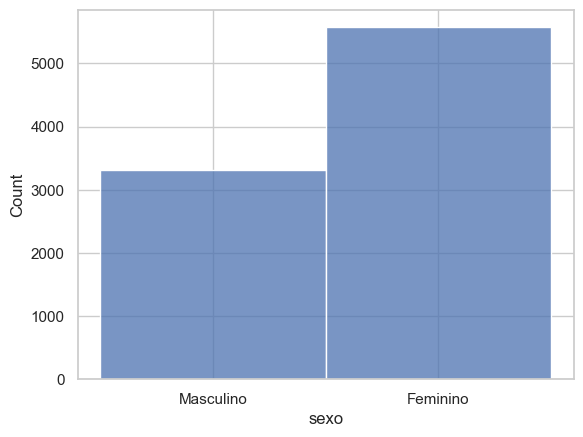

In [16]:
sns.histplot(pacientes.sexo)
plt.show()

In [17]:
pacientes.sexo.value_counts() / 100

sexo
Feminino     55.71
Masculino    33.05
Name: count, dtype: float64

**Observações**
- A base de pacientes possui muitos valores nulos, muitas informações não são coletadas no momento do cadastro.
- A coluna bairro possui 520 valores únicos e 1638 valores nulos.
- Ainda na coluna bairro, a quantidade de valores únicos pode ser reduzida, pois muitos valores são redundantes e escritos de maneiras diferentes.
- Assim como na coluna bairro, a coluna plano possui valores redudantes e escritos de maneiras diferentes.
- A coluna convênio tem a mesma informação que se propõe a coluna plano.
- Atualmente apenas os planos/convênio PLANSERV, ASTEBA, ASSEBA E PARATODOS são aceitos, portanto os que não enquadram-se passam a ser PARTICULAR.
- O público feminino equivale a quase o dobro do público masculino.
- Transformaremos o tipo das colunas de data para um modelo que fique melhor de trabalhar.

### BASE DE PRODUTIVIDADE

In [18]:
produtividade.head()

agendado em data do agendamento hora do agendamento              medico  \
0  06/11/2024          25/12/2024               16:30        PSICOLOGISTA   
1  06/11/2024          25/12/2024               16:30        PSICOLOGISTA   
2  06/11/2024          18/12/2024               16:30        PSICOLOGISTA   
3  06/11/2024          18/12/2024               16:30        PSICOLOGISTA   
4  22/11/2024          17/12/2024               14:00  ULTRASSONOGRAFISTA   

               idade  id amigo                 tipo de atendimento  \
0            64 anos  42510843  PACOTE DE PSICOLOGIA COM 8 SESSÕES   
1  13 anos e 8 meses  81745516  PACOTE DE PSICOLOGIA COM 8 SESSÕES   
2            64 anos  42510843  PACOTE DE PSICOLOGIA COM 8 SESSÕES   
3  13 anos e 8 meses  81745516  PACOTE DE PSICOLOGIA COM 8 SESSÕES   
4                NaN  82366075                    ULTRASSONOGRAFIA   

  status do agendamento forma de pagamento  valor  
0              Agendado             Cartão   65.0  
1              Agendado             Cartão   65.0  
2              Agendado             Cartão   65.0  
3              Agendado             Cartão   65.0  
4              Agendado           Pendente  100.0

In [19]:
produtividade.tail()

agendado em data do agendamento hora do agendamento              medico  \
7275  26/12/2024          27/12/2024               11:00  ULTRASSONOGRAFISTA   
7276  26/12/2024          27/12/2024               11:00  ULTRASSONOGRAFISTA   
7277  16/12/2024          27/12/2024               13:40        PSICOLOGISTA   
7278  20/12/2024          27/12/2024               14:00        PSICOLOGISTA   
7279  06/11/2024          27/12/2024               16:30        PSICOLOGISTA   

                  idade  id amigo                 tipo de atendimento  \
7275            42 anos  84385304                    ULTRASSONOGRAFIA   
7276            42 anos  84385304                    ULTRASSONOGRAFIA   
7277            37 anos  76977195               CONSULTA PSICOLOGISTA   
7278  14 anos e 2 meses  77124782               CONSULTA PSICOLOGISTA   
7279            14 anos  81745516  PACOTE DE PSICOLOGIA COM 8 SESSÕES   

     status do agendamento forma de pagamento   valor  
7275            Confirmado           Pendente  100.00  
7276            Confirmado           Pendente  100.00  
7277              Cancelou          PARATODOS   43.56  
7278            Finalizado          PARATODOS   43.56  
7279            Finalizado             Cartão   65.00

In [20]:
produtividade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7280 entries, 0 to 7279
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   agendado em            7280 non-null   object 
 1   data do agendamento    7280 non-null   object 
 2   hora do agendamento    7280 non-null   object 
 3   medico                 7280 non-null   object 
 4   idade                  6589 non-null   object 
 5   id amigo               7280 non-null   int64  
 6   tipo de atendimento    7280 non-null   object 
 7   status do agendamento  7280 non-null   object 
 8   forma de pagamento     7280 non-null   object 
 9   valor                  7280 non-null   float64
dtypes: float64(1), int64(1), object(8)
memory usage: 568.9+ KB


In [21]:
produtividade['id amigo'].duplicated().sum()

4226

In [22]:
produtividade['status do agendamento'].unique()

array(['Agendado', 'Finalizado', 'Faltou', 'Cancelou', 'Confirmado',
       'Presente', 'Em atendimento'], dtype=object)

In [23]:
(produtividade['status do agendamento'].value_counts())

status do agendamento
Finalizado        5815
Agendado          1043
Cancelou           242
Faltou              72
Confirmado          48
Presente            33
Em atendimento      27
Name: count, dtype: int64

In [24]:
produtividade.idade.isnull().sum()

691

In [25]:
produtividade.idade.dtypes

dtype('O')

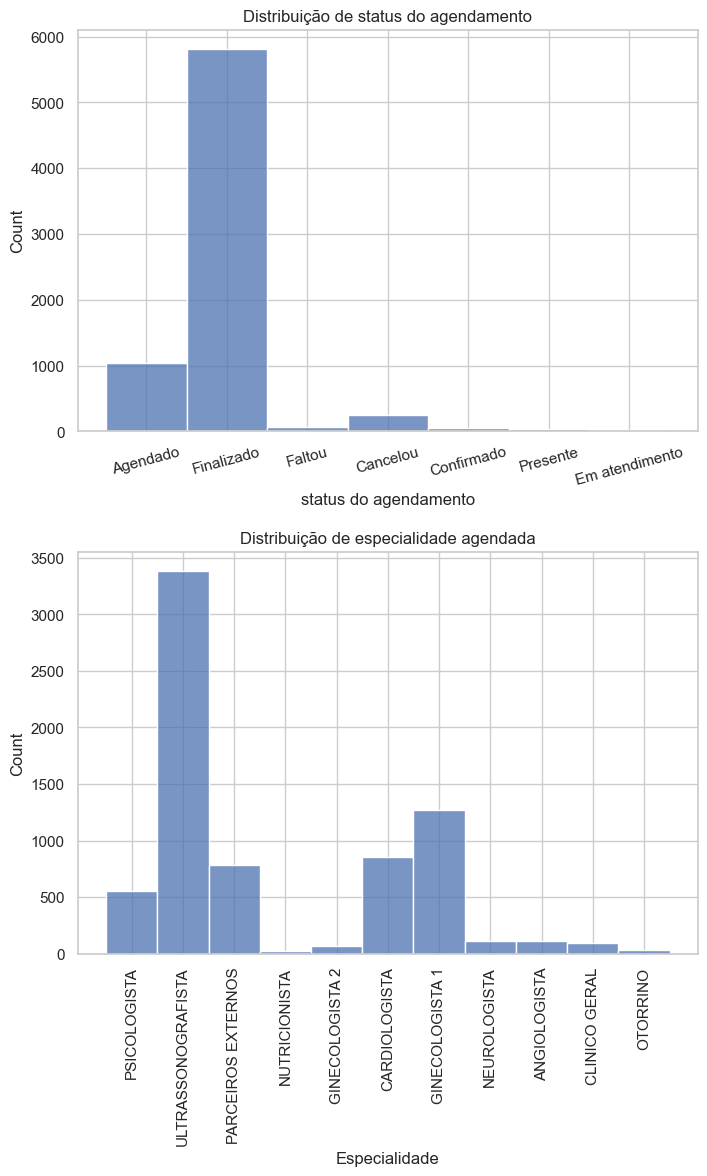

In [26]:
fig , ax = plt.subplots(2 , 1 , figsize = (8 , 12))

sns.histplot(produtividade['status do agendamento'] , ax = ax[0])
ax[0].tick_params(axis='x', rotation=15)
ax[0].set_title('Distribuição de status do agendamento')

sns.histplot(produtividade['medico'] , ax = ax[1] , cbar = True)
ax[1].tick_params(axis='x' , rotation = 90)
ax[1].set_xlabel('Especialidade')
ax[1].set_title('Distribuição de especialidade agendada')
#ax[1].tick_params(axis='x', rotation=45)

plt.subplots_adjust(hspace=0.3)
#plt.tight_layout()
plt.show()


In [27]:
produtividade.medico.value_counts()

medico
ULTRASSONOGRAFISTA    3383
GINECOLOGISTA 1       1270
CARDIOLOGISTA          853
PARCEIROS EXTERNOS     786
PSICOLOGISTA           552
NEUROLOGISTA           110
ANGIOLOGISTA           109
CLINICO GERAL           94
GINECOLOGISTA 2         69
OTORRINO                29
NUTRICIONISTA           25
Name: count, dtype: int64

In [28]:
produtividade['id amigo'].isnull().sum()

0

**Observações**
- A base de produtividade possui ID's duplicados, o que faz sentido, pois o mesmo paciente visitou a clínica mais de uma vez durante os dois anos de análise.
- 981 agendamentos permanecem com status 'agendado'. Excluindo datas futuras, isso indica que os pacientes faltaram ao agendamento.
- 41 pacientes confirmaram presença, mas, se não se referem a datas futuras, esses também faltaram ao atendimento, pois o status correto deveria ser 'finalizado'.
- 30 pacientes listados como 'presente' e 26 como 'em atendimento' deveriam estar com status 'finalizado', já que compareceram à clínica na data do atendimento.
- A coluna idade possui 259 dados faltantes e o formato está como object, isso por que está acompanhada do sufixo 'anos'     

### BASE REPASSES

In [29]:
repasse.head()

data atend  id amigo forma de pagamento              medico  \
0  2023-01-03 00:00:00  42512119             Cartão  ULTRASSONOGRAFISTA   
1  2023-01-03 00:00:00  42510350           PLANSERV  ULTRASSONOGRAFISTA   
2  2023-01-05 00:00:00  49663272           Dinheiro  ULTRASSONOGRAFISTA   
3  2023-01-05 00:00:00  49668596             Cartão  ULTRASSONOGRAFISTA   
4  2023-01-05 00:00:00  43189318             Cartão  ULTRASSONOGRAFISTA   

                      procedimento/matmed  faturado  desconto  líquido  \
0           ULTRASSONOGRAFIA TRANSVAGINAL     90.00     2.286   87.714   
1  ULTRASSONOGRAFIA PARTES MOLES EM GERAL     34.72     0.000   34.720   
2           ULTRASSONOGRAFIA ABDOME TOTAL     90.00     0.000   90.000   
3     ULTRASSONOGRAFIA PRÓSTATA ABDOMINAL     90.00     2.286   87.714   
4     OBSTÉTRICA MORFOLÓGICA 2º TRIMESTRE    180.00     0.000  180.000   

   repasse executante  
0              88.857  
1              34.720  
2              90.000  
3              88.857  
4             180.000

In [30]:
repasse.tail()

data atend  id amigo forma de pagamento           medico  \
4811  17/12/2024  42511020           Dinheiro  GINECOLOGISTA 1   
4812  17/12/2024  42511020             Cartão  GINECOLOGISTA 1   
4813  26/11/2024  42509292           Dinheiro  GINECOLOGISTA 2   
4814  26/11/2024  82476751          PARATODOS  GINECOLOGISTA 2   
4815  03/12/2024  42508411             Cartão  GINECOLOGISTA 2   

                 procedimento/matmed    faturado  desconto     líquido  \
4811           CONSULTA GINECOLÓGICA   96.923077     0.000   96.923077   
4812           CONSULTA GINECOLÓGICA   43.076923     1.016   42.060923   
4813  PACOTE CONSULTA+PREVENTIVO+USG  330.000000     0.000  330.000000   
4814             CONSULTA+PREVENTIVO  167.000000     0.000  167.000000   
4815             CONSULTA+PREVENTIVO  230.000000     3.151  226.849000   

      repasse executante  
4811             48.4615  
4812             21.0305  
4813            120.0000  
4814            115.0000  
4815            113.4245

In [31]:
repasse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4816 entries, 0 to 4815
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   data atend           4816 non-null   object 
 1   id amigo             4816 non-null   int64  
 2   forma de pagamento   4816 non-null   object 
 3   medico               4816 non-null   object 
 4   procedimento/matmed  4816 non-null   object 
 5   faturado             4816 non-null   float64
 6   desconto             4816 non-null   float64
 7   líquido              4816 non-null   float64
 8   repasse executante   4816 non-null   float64
dtypes: float64(4), int64(1), object(4)
memory usage: 338.8+ KB


In [32]:
print('A quantidade de exames no catálogo é de {} exames'.format(repasse['procedimento/matmed'].nunique()))
print('A média de descontos/taxas é de R${:.2f}'.format(repasse.desconto.mean()))

A quantidade de exames no catálogo é de 81 exames
A média de descontos/taxas é de R$1.31


In [33]:
top_procedimentos = repasse['procedimento/matmed'].value_counts().head(15).reset_index()
top_procedimentos.columns = ['procedimentos' , 'quantidade']
top_procedimentos

procedimentos  quantidade
0            ULTRASSONOGRAFIA ABDOME TOTAL         595
1            ULTRASSONOGRAFIA TRANSVAGINAL         390
2                   ULTRASSONOGRAFIA MAMAS         298
3                                      ECG         293
4                   CONSULTA CARDIOLOGISTA         282
5                      CONSULTA+PREVENTIVO         257
6   ULTRASSONOGRAFIA PARTES MOLES EM GERAL         246
7                           ECOCARDIOGRAMA         230
8                    CONSULTA PSICOLOGISTA         196
9                ULTRASSONOGRAFIA TIREÓIDE         175
10             ULTRASSONOGRAFIA OBSTÉTRICA         142
11                                    MAPA         119
12                   CONSULTA GINECOLÓGICA         115
13                 CONSULTA OFTALMOLOGISTA         112
14     OBSTÉTRICA MORFOLÓGICA 2º TRIMESTRE          92

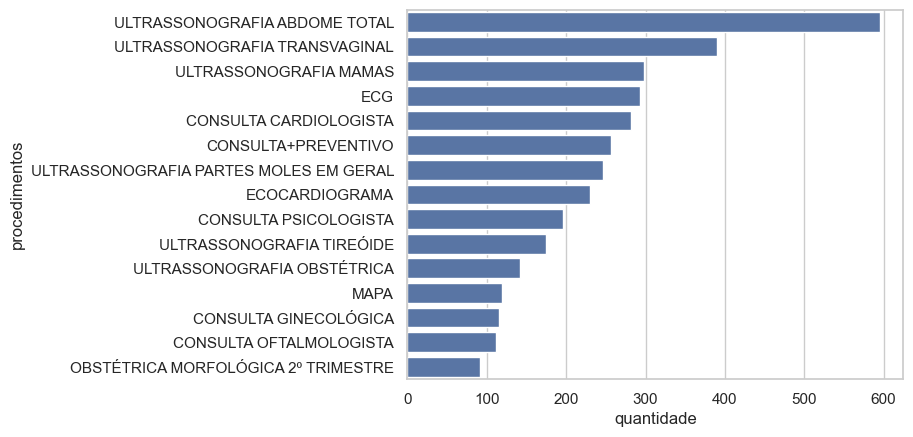

In [34]:
sns.barplot(data = top_procedimentos , x = 'quantidade' , y = 'procedimentos')

plt.show()

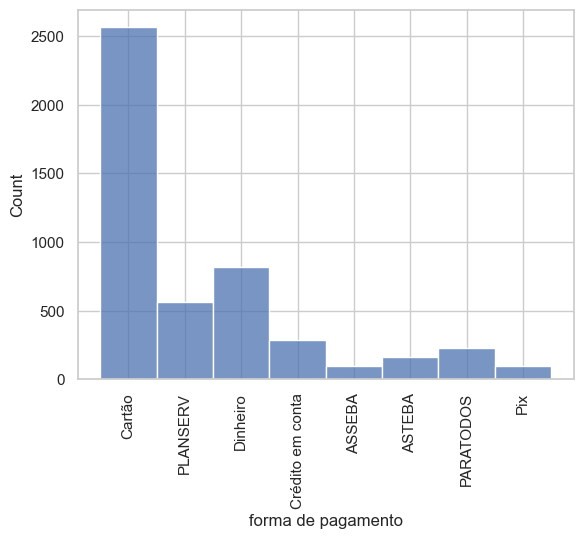

In [35]:
sns.histplot(repasse['forma de pagamento']);
plt.xticks(rotation=90)

plt.show()

In [36]:
variaveis = list(repasse.columns)
variaveis = [var for var in variaveis if var not in ['index', 'data_ref']]
variaveis_quali = [var for var in variaveis if repasse[var].dtype == 'object']
variaveis_quant = [var for var in variaveis if repasse[var].dtype != 'object']

In [37]:
for var in variaveis_quali:
    print(f'\n{var}:')
    print(repasse[var].value_counts())


data atend:
data atend
2024-11-22    29
2024-04-11    26
2024-03-28    25
2023-01-25    24
2024-01-26    23
              ..
2023-05-29     1
2023-06-22     1
2023-04-15     1
2023-05-06     1
2024-06-10     1
Name: count, Length: 533, dtype: int64

forma de pagamento:
forma de pagamento
Cartão              2567
Dinheiro             821
PLANSERV             566
Crédito em conta     287
PARATODOS            228
ASTEBA               160
Pix                   94
ASSEBA                93
Name: count, dtype: int64

medico:
medico
ULTRASSONOGRAFISTA    2499
GINECOLOGISTA 1        660
CARDIOLOGISTA          558
PARCEIROS EXTERNOS     501
PSICOLOGISTA           374
ANGIOLOGISTA            69
CLINICO GERAL           48
NEUROLOGISTA            47
GINECOLOGISTA 2         26
NUTRICIONISTA           19
OTORRINO                15
Name: count, dtype: int64

procedimento/matmed:
procedimento/matmed
ULTRASSONOGRAFIA ABDOME TOTAL    595
ULTRASSONOGRAFIA TRANSVAGINAL    390
ULTRASSONOGRAFIA MAMAS       

**Observações**
- A clinica possui 80 procedimentos no catálogo.
- Dos procedimentos mais realizados, 3 são ultrassonografia.
- A forma de pagamento mais útilizada é cartão de débito/crédito, seguida de pagamento em espécie.
- As formas de pagamento 'Crédito em conta' e 'pix' são redundantes.

## Etapa 3 Crisp-DM: Preparação dos dados

### TRATAMENTOS

#### Tratando a base de pacientes

In [38]:
#função para deixar todos os nomes em caixa alta e trocar erros de escrita por valores corretos.
def padronizar_bairro(bairro):
    if pd.isna(bairro):
        return "NÃO INFORMADO"
    bairro = bairro.upper().strip()
    mapeamento = {
    'ITAPUÃ': 'ITAPUÃ',
    'ITAPUAN': 'ITAPUÃ',
    'IMBUI': 'IMBUÍ',
    'IMBUÍ': 'IMBUÍ',
    'VILAS DO ATLANTICO': 'VILAS DO ATLÂNTICO',
    'VILAS DO ATLÂNTICO': 'VILAS DO ATLÂNTICO',
    '7 DE ABRIL': '7 DE ABRIL',
    'SETE DE ABRIL': '7 DE ABRIL',
    'SÃO CAETANO': 'SÃO CAETANO',
    'SAO CAETANO': 'SÃO CAETANO',
    'FAROL DE ITAPUÃ': 'FAROL DE ITAPUÃ',
    'JARDIM ARMAÇÃO': 'JARDIM ARMAÇÃO',
    'CAMAÇARI': 'CAMAÇARI',
    'CAMAÇARI DE DENTRO': 'CAMAÇARI',
    'JAGUARIPE 1': 'JAGUARIBE',
    'JAGUARIPE': 'JAGUARIBE',
    'IPITANGA LAURO DE FREITAS' : 'IPITANGA',
    'ALPHAVILLE I' : 'ALPHAVILLE' ,
    'ALPHAVILE 1' : 'ALPHAVILLE',
    'PARAFUSO' : 'VIA PARAFUSO',
    'CAZEIRAS 11' : 'CAJAZEIRAS',
    'SAN MARTIN' : 'SAN MARTINS',
    'JARDIM PLACAFORD' : 'PLACAFORD'
    
    #adicionar mais caso necessário    
    }
    return mapeamento.get(bairro, bairro)
    

In [39]:
def padronizar_plano(plano):
    planos_ativos = ['PARATODOS', 'ASSEBA', 'ASTEBA', 'PLANSERV']
    

    if pd.isna(plano):
        return 'PARTICULAR'
    
    if not isinstance(plano, str):
        return 'PARTICULAR'
    
    plano = plano.upper().strip()

    if plano in planos_ativos:
        return plano
    else:
        return 'PARTICULAR'



In [40]:
pacientes.plano.unique()

array([nan, 'PLANSERV', 'SULAMERICA', 'Particular', 'GOLDEN CROSS',
       'PETROBRAS', 'Sul America', 'ASTEBA', 'ASSEBA', 'Asseba', 'AMS',
       'IPS', 'Unimed', 'SUL AMERICA', '312', 'GEAP', 'ams',
       'empresarial', 'cortesia', 'central nacional', 'sulamerica',
       'UNIMED', '0569116023', 'Uniplan', 'asseba', '0516738780',
       'Basico 445', '76527450559', 'especial', 'Ams', 'Classico',
       'UNIMED RIO', 'SUL AMÉRICA', 'CORTEZIA', 'UNIMED SEGUROS',
       'Especial', 'SAÚDE BRADESCO', 'unimed', 'unimed seguros',
       '10723099553005', 'CORTESIA', 'SULAMÉRICA', 'Sulamerica',
       'MEDISERVICE', '08327084534006', 'Enfermaria  MTE', 'geap',
       'medial', '010003649903', 'PROMÉDICA', 'Norte/Nordeste',
       'Curitiba', 'Central nacional', 'norte nordeste', 'MARIGA',
       'Central  Nacional', 'Norte Nordeste', 'NORTE NORDESTE', 'RIO',
       'paratodos', 'PARATODOS', 'Paratodos', 'Sul Mineira',
       'costa do descobrimento', 'cortersia', 'Bradesco Saúde', 'rio',
 

In [41]:
pacientes['bairro'] = pacientes['bairro'].apply(padronizar_bairro)

In [42]:
pacientes.plano = pacientes.plano.apply(padronizar_plano)

In [43]:
pacientes.plano.value_counts()

plano
PARTICULAR    8129
PLANSERV      1554
ASTEBA         199
ASSEBA          93
PARATODOS       58
Name: count, dtype: int64

In [44]:
#Retirando a coluna convênio da base
pacientes = pacientes.drop(columns = 'convênio')

In [45]:
#Colocando as colunas de data em tipo datetime
pacientes[['data de nascimento' , 
           'data do último agendamento' ,
           'data do próximo agendamento' , 
           'data de criação']] = pacientes[['data de nascimento' , 
                                        'data do último agendamento',
                                        'data do próximo agendamento',
                                        'data de criação']].apply(pd.to_datetime , errors = 'coerce' , dayfirst = True)

In [46]:
pacientes[['data de nascimento' , 'data do último agendamento' ,'data do próximo agendamento', 'data de criação']].dtypes

data de nascimento             datetime64[ns]
data do último agendamento     datetime64[ns]
data do próximo agendamento    datetime64[ns]
data de criação                datetime64[ns]
dtype: object

In [47]:
pacientes['idade'] = pacientes['data de nascimento'].apply(lambda x : (datetime.now() - x).days // 365)

In [48]:
pacientes['idade']

0        46.0
1        70.0
2        42.0
3        55.0
4        52.0
         ... 
10028    29.0
10029    32.0
10030     NaN
10031     NaN
10032     NaN
Name: idade, Length: 10033, dtype: float64

#### Tratando a base de produtividade

In [49]:
produtividade[['data do agendamento' , 
               'agendado em']] = produtividade[['data do agendamento' , 
                                'agendado em']].apply(pd.to_datetime , errors = 'coerce' , dayfirst = True)

In [50]:
produtividade = produtividade.drop(columns = 'idade')
produtividade = produtividade.merge(pacientes[['id amigo', 'idade']], on='id amigo', how='left')

In [51]:
produtividade['status do agendamento'].value_counts()

status do agendamento
Finalizado        5815
Agendado          1043
Cancelou           242
Faltou              72
Confirmado          48
Presente            33
Em atendimento      27
Name: count, dtype: int64

In [52]:
def padronizar_status(status_col, data_col):
    status = []
    
    for status_atual, data_agendamento in zip(status_col, data_col):
        if status_atual in ['Finalizado', 'Faltou']:
            status.append(status_atual)
        elif status_atual in ['Agendado', 'Confirmado']:
            if data_agendamento < datetime.now():
                status.append('Faltou')
            else:
                status.append('Agendado')
        elif status_atual in ['Presente', 'Em atendimento']:
            status.append('Finalizado')
        elif status_atual == 'Cancelou':
            status.append('Cancelado')
        else:
            # Mantém o valor original se não se enquadrar em nenhum caso anterior
            status.append(status_atual)
    
    return status



In [53]:
produtividade['status do agendamento'] = padronizar_status(produtividade['status do agendamento'] , produtividade['data do agendamento'])

In [54]:
produtividade['status do agendamento'].value_counts()

status do agendamento
Finalizado    5875
Faltou        1163
Cancelado      242
Name: count, dtype: int64

#### Tratando a base de repasses

In [55]:
repasse['data atend'] = pd.to_datetime(repasse['data atend'] , errors = 'coerce' , dayfirst = True)

In [56]:
repasse['forma de pagamento'] = repasse['forma de pagamento'].replace('Pix' , 'Crédito em conta')

In [57]:
repasse['forma de pagamento'].value_counts()

forma de pagamento
Cartão              2567
Dinheiro             821
PLANSERV             566
Crédito em conta     381
PARATODOS            228
ASTEBA               160
ASSEBA                93
Name: count, dtype: int64

In [58]:
repasse.head()

data atend  id amigo forma de pagamento              medico  \
0 2023-01-03  42512119             Cartão  ULTRASSONOGRAFISTA   
1 2023-01-03  42510350           PLANSERV  ULTRASSONOGRAFISTA   
2 2023-01-05  49663272           Dinheiro  ULTRASSONOGRAFISTA   
3 2023-01-05  49668596             Cartão  ULTRASSONOGRAFISTA   
4 2023-01-05  43189318             Cartão  ULTRASSONOGRAFISTA   

                      procedimento/matmed  faturado  desconto  líquido  \
0           ULTRASSONOGRAFIA TRANSVAGINAL     90.00     2.286   87.714   
1  ULTRASSONOGRAFIA PARTES MOLES EM GERAL     34.72     0.000   34.720   
2           ULTRASSONOGRAFIA ABDOME TOTAL     90.00     0.000   90.000   
3     ULTRASSONOGRAFIA PRÓSTATA ABDOMINAL     90.00     2.286   87.714   
4     OBSTÉTRICA MORFOLÓGICA 2º TRIMESTRE    180.00     0.000  180.000   

   repasse executante  
0              88.857  
1              34.720  
2              90.000  
3              88.857  
4             180.000

### Criando Base Final

In [59]:
df_fin = pacientes[['id amigo' , 'sexo' , 'bairro' , 'plano']]
df_fin = df_fin.merge(repasse , on = 'id amigo' , how = 'right').dropna().reset_index()
df_fin.drop(columns = 'index' , inplace = True)

In [60]:
df_fin.head()

id amigo       sexo                 bairro       plano data atend  \
0  42512119   Feminino  JARDIM DAS MARGARIDAS  PARTICULAR 2023-01-03   
1  42510350   Feminino                 ITAPUÃ    PLANSERV 2023-01-03   
2  43189318   Feminino          BAIRRO DA PAZ  PARTICULAR 2023-01-05   
3  42510093  Masculino                 ITAPUÃ    PLANSERV 2023-01-05   
4  42512574   Feminino                   CAJI  PARTICULAR 2023-01-05   

  forma de pagamento              medico  \
0             Cartão  ULTRASSONOGRAFISTA   
1           PLANSERV  ULTRASSONOGRAFISTA   
2             Cartão  ULTRASSONOGRAFISTA   
3           Dinheiro  ULTRASSONOGRAFISTA   
4             Cartão  ULTRASSONOGRAFISTA   

                      procedimento/matmed  faturado  desconto  líquido  \
0           ULTRASSONOGRAFIA TRANSVAGINAL     90.00     2.286   87.714   
1  ULTRASSONOGRAFIA PARTES MOLES EM GERAL     34.72     0.000   34.720   
2     OBSTÉTRICA MORFOLÓGICA 2º TRIMESTRE    180.00     0.000  180.000   
3     ULTRASSONOGRAFIA PRÓSTATA ABDOMINAL     90.00     0.000   90.000   
4           ULTRASSONOGRAFIA TRANSVAGINAL     90.00     2.286   87.714   

   repasse executante  
0              88.857  
1              34.720  
2             180.000  
3              90.000  
4              88.857

In [61]:
df_fin['faturamento_clinica'] = df_fin.apply(
    lambda row: row['líquido'] if row['medico'] == 'ULTRASSONOGRAFISTA' else row['líquido'] - row['repasse executante'],
    axis=1
)

In [62]:
df_fin.head()

id amigo       sexo                 bairro       plano data atend  \
0  42512119   Feminino  JARDIM DAS MARGARIDAS  PARTICULAR 2023-01-03   
1  42510350   Feminino                 ITAPUÃ    PLANSERV 2023-01-03   
2  43189318   Feminino          BAIRRO DA PAZ  PARTICULAR 2023-01-05   
3  42510093  Masculino                 ITAPUÃ    PLANSERV 2023-01-05   
4  42512574   Feminino                   CAJI  PARTICULAR 2023-01-05   

  forma de pagamento              medico  \
0             Cartão  ULTRASSONOGRAFISTA   
1           PLANSERV  ULTRASSONOGRAFISTA   
2             Cartão  ULTRASSONOGRAFISTA   
3           Dinheiro  ULTRASSONOGRAFISTA   
4             Cartão  ULTRASSONOGRAFISTA   

                      procedimento/matmed  faturado  desconto  líquido  \
0           ULTRASSONOGRAFIA TRANSVAGINAL     90.00     2.286   87.714   
1  ULTRASSONOGRAFIA PARTES MOLES EM GERAL     34.72     0.000   34.720   
2     OBSTÉTRICA MORFOLÓGICA 2º TRIMESTRE    180.00     0.000  180.000   
3     ULTRASSONOGRAFIA PRÓSTATA ABDOMINAL     90.00     0.000   90.000   
4           ULTRASSONOGRAFIA TRANSVAGINAL     90.00     2.286   87.714   

   repasse executante  faturamento_clinica  
0              88.857               87.714  
1              34.720               34.720  
2             180.000              180.000  
3              90.000               90.000  
4              88.857               87.714

In [63]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4132 entries, 0 to 4131
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id amigo             4132 non-null   int64         
 1   sexo                 4132 non-null   object        
 2   bairro               4132 non-null   object        
 3   plano                4132 non-null   object        
 4   data atend           4132 non-null   datetime64[ns]
 5   forma de pagamento   4132 non-null   object        
 6   medico               4132 non-null   object        
 7   procedimento/matmed  4132 non-null   object        
 8   faturado             4132 non-null   float64       
 9   desconto             4132 non-null   float64       
 10  líquido              4132 non-null   float64       
 11  repasse executante   4132 non-null   float64       
 12  faturamento_clinica  4132 non-null   float64       
dtypes: datetime64[ns](1), float64(5),

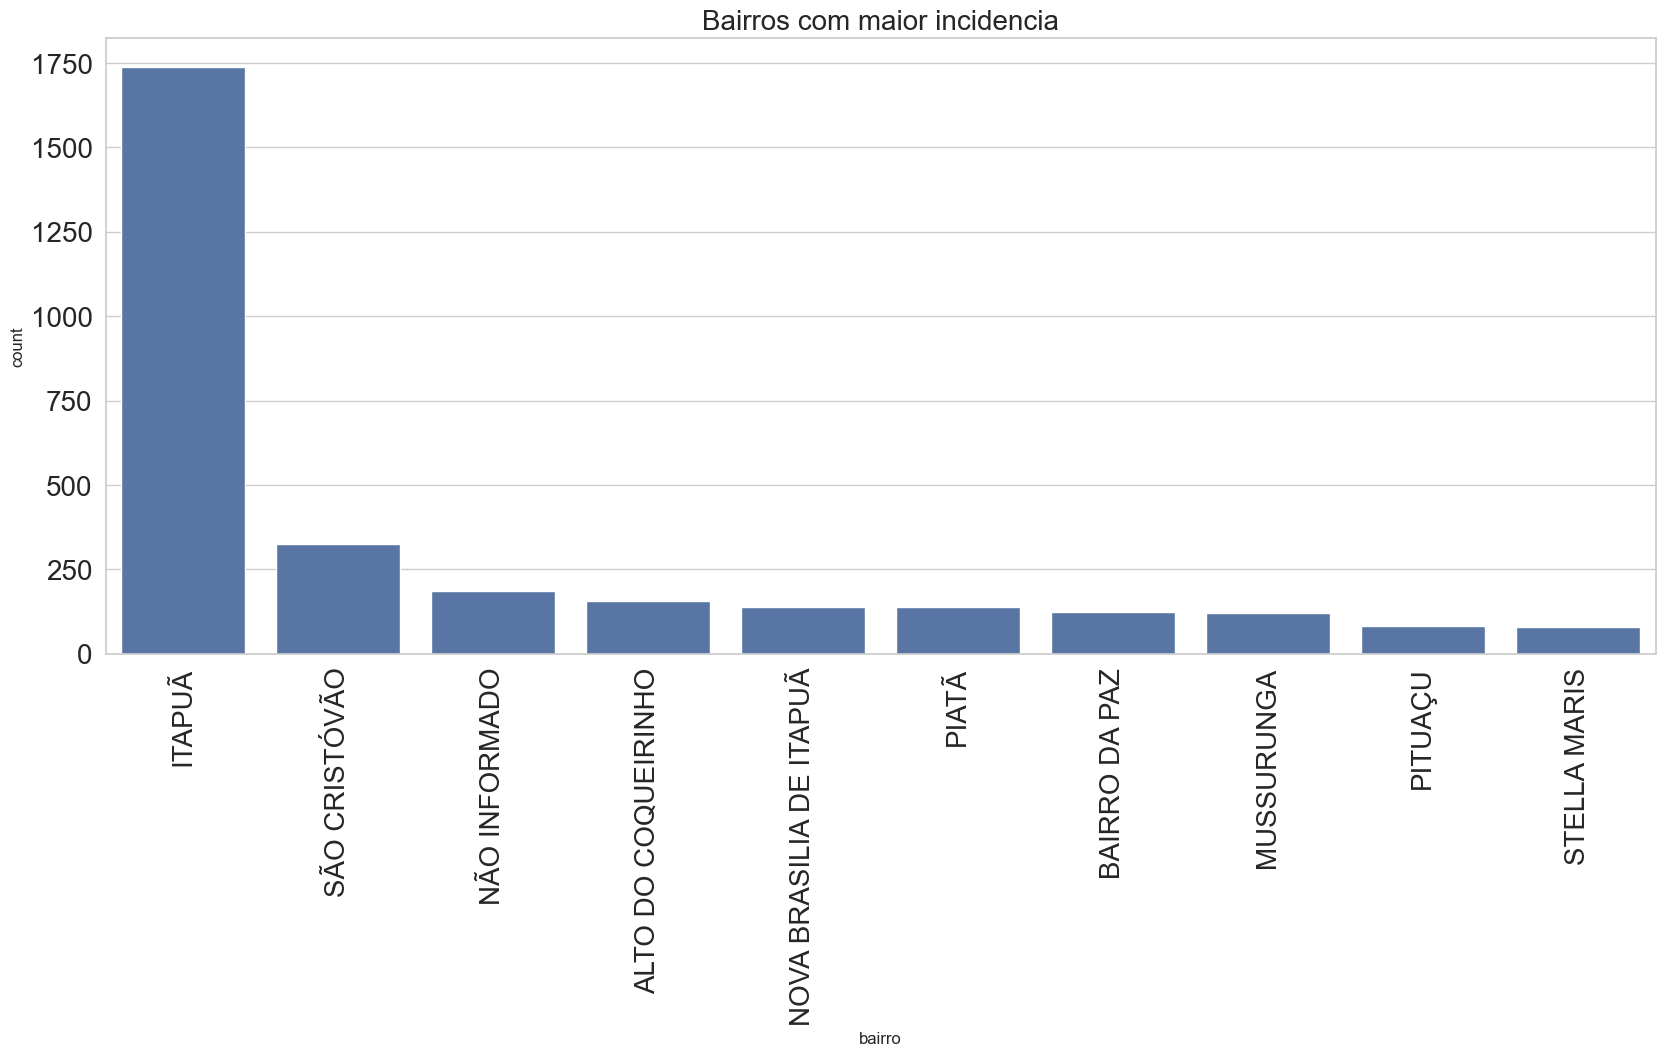

In [64]:
plt.figure(figsize = (20 , 8))
sns.barplot(df_fin.bairro.value_counts().head(10))
plt.xticks(rotation=90)
plt.title('Bairros com maior incidencia', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

Pra categorizar as regiões decidi incluir os bairros com mais de 55 amostras. Bairros com amostras menores que isso serão incluidos na catégoria outros.

In [65]:
def categorizar_regiao(bairro):
    if bairro in ["ITAPUÃ", "NOVA BRASILIA DE ITAPUÃ", "ALTO DO COQUEIRINHO", "PLACAFORD", 
                  "FAZENDA GRANDE DO RETIRO", "ITINGA", "PIATÃ", "MUSSURUNGA", "STELLA MARIS", 
                  "BAIRRO DA PAZ", "CASSANGE" , "PARQUE SÃO CRISTÓVÃO",  "SÃO CRISTÓVÃO"]:
        return 'Região de Itapuã e São Cristóvão'
    elif bairro in ["SUSSURANA", "PAU DA LIMA", "VILA RUY BARBOSA", "PERNAMBUÉS", 
                    "JARDIM NOVA ESPERANÇA", "TROBOGY", "PITUÁÇU", "SÃO MARCOS", "TANCREDO NEVES"]:
        return 'Subúrbio e Região Norte de Salvador'
    elif bairro in ["LIBERDADE", "CAJI", "CENTRO", 
                    "CAIXA D'ÁGUA", "VIDA NOVA", "CASTELO BRANCO", 
                    "7 DE ABRIL", "SANTA CRUZ"]:
        return 'Centro de Salvador e Regiões Circunvizinhas'
    elif bairro in ["CAMAÇARI", "PORTO DE SAUIPE", "PRAIA DO FLAMENGO"]:
        return 'Litoral Norte de Salvador e Municípios Vizinhos'
    else:
        return 'Outras regiões'

In [66]:
df_fin['regiao'] = df_fin.bairro.apply(categorizar_regiao)

#### Filtro ano de 2023

In [67]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4132 entries, 0 to 4131
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id amigo             4132 non-null   int64         
 1   sexo                 4132 non-null   object        
 2   bairro               4132 non-null   object        
 3   plano                4132 non-null   object        
 4   data atend           4132 non-null   datetime64[ns]
 5   forma de pagamento   4132 non-null   object        
 6   medico               4132 non-null   object        
 7   procedimento/matmed  4132 non-null   object        
 8   faturado             4132 non-null   float64       
 9   desconto             4132 non-null   float64       
 10  líquido              4132 non-null   float64       
 11  repasse executante   4132 non-null   float64       
 12  faturamento_clinica  4132 non-null   float64       
 13  regiao               4132 non-nul

In [68]:
dados_2023 = df_fin[df_fin['data atend'].dt.year == 2023].copy()
dados_2023.loc[:, 'mes_ano'] = dados_2023['data atend'].dt.to_period('M')

In [69]:
prod_mens_2023 = dados_2023.groupby(['mes_ano' , 'medico'])['líquido'].sum().reset_index()
prod_mens_2023['mes_ano'] = prod_mens_2023['mes_ano'].astype(str)

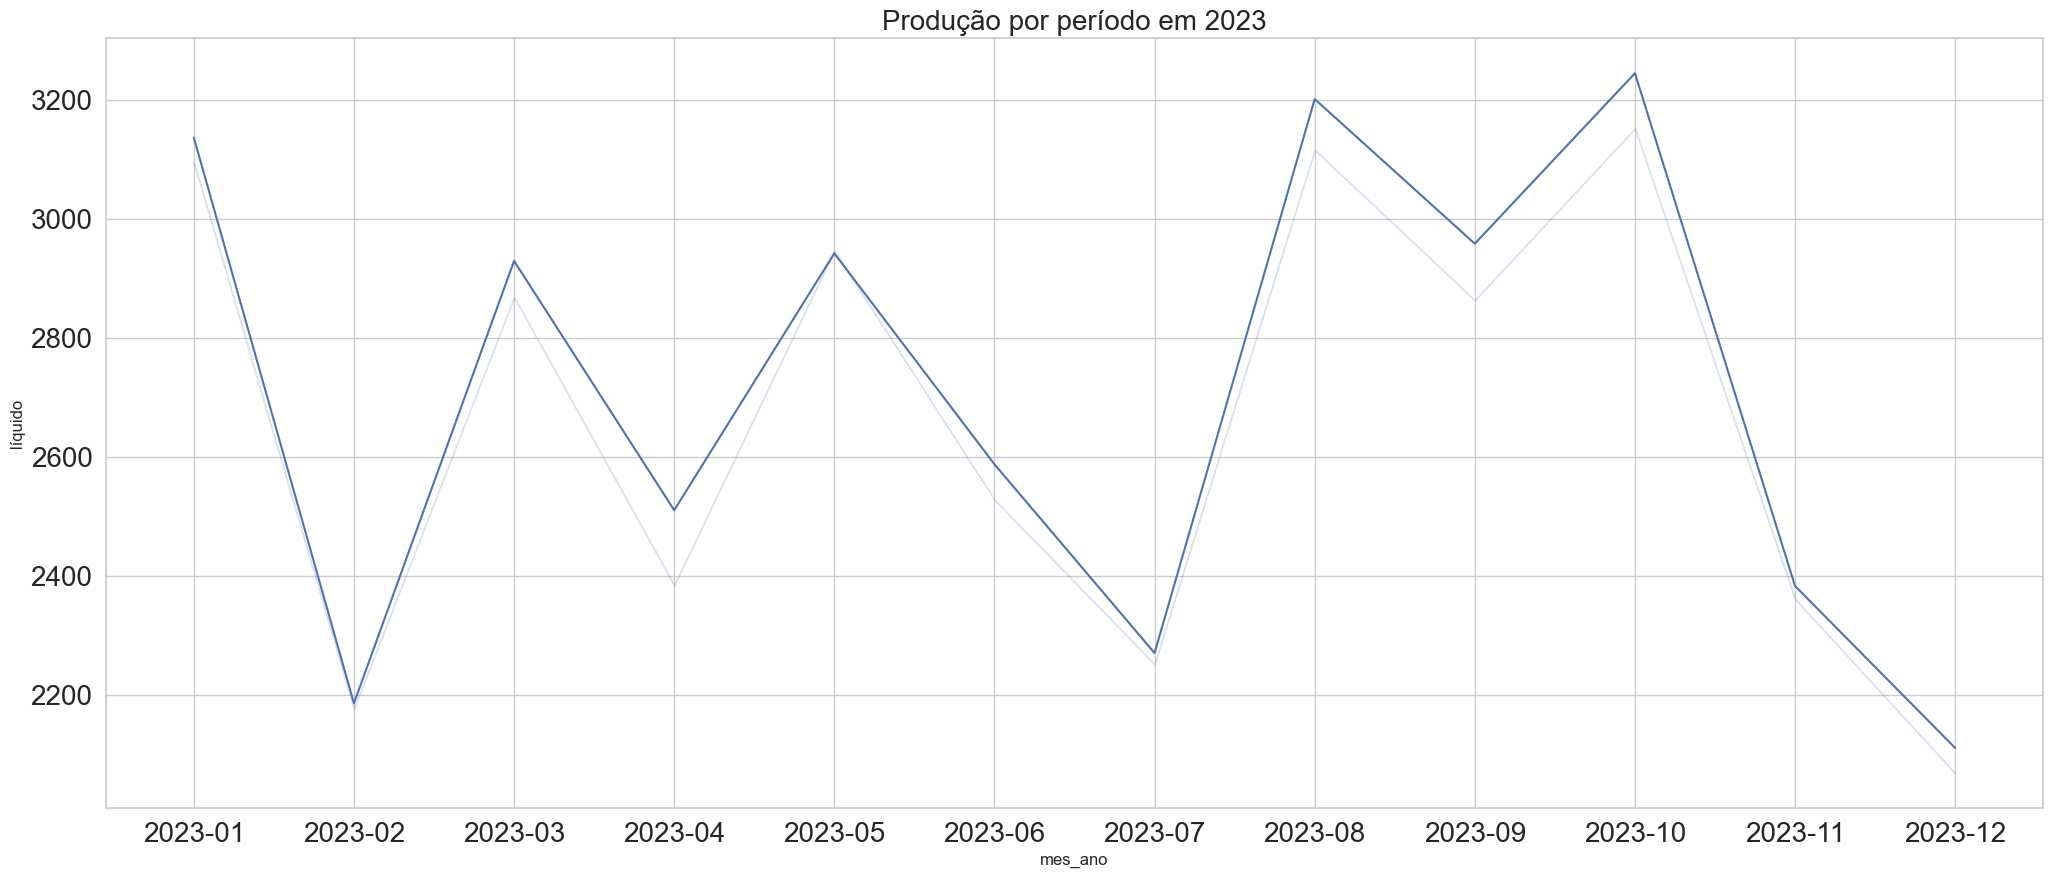

In [70]:
plt.figure(figsize = (25 , 10))
sns.lineplot(data = prod_mens_2023 , x = 'mes_ano' , y = 'líquido' , errorbar = ('ci' , 0))

plt.title('Produção por período em 2023', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

In [71]:
especialidades = produtividade.medico.unique()

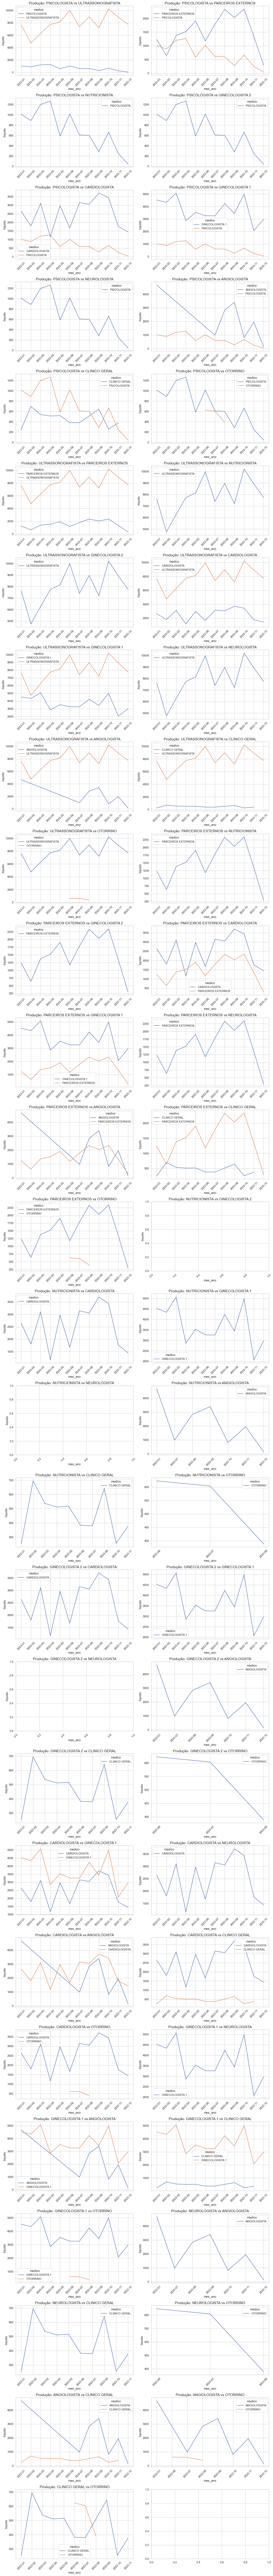

In [72]:
num_graficos = len(especialidades) * (len(especialidades) - 1) // 2  # Combinações únicas
linhas = (num_graficos + 1) // 2  # Duas colunas, então divide por 2

fig, ax = plt.subplots(linhas, 2, figsize=(15, linhas * 5))  # Ajusta o tamanho

idx = 0  # Índice para percorrer os subplots
for i, esp1 in enumerate(especialidades):
    for esp2 in especialidades[i+1:]:  # Evita repetição de combinações
        row, col = divmod(idx, 2)  # Calcula posição do subplot
        filtro = prod_mens_2023[prod_mens_2023['medico'].isin([esp1, esp2])]

        sns.lineplot(data=filtro, x='mes_ano', y='líquido', hue='medico', ax=ax[row, col], errorbar=('ci', 0))
        ax[row, col].set_title(f'Produção: {esp1} vs {esp2}', fontsize=14)
        ax[row, col].tick_params(axis='x', rotation=45)

        idx += 1  # Atualiza índice

plt.tight_layout()  # Ajusta o espaçamento entre os gráficos
plt.show()


In [73]:
prod_genero23 = dados_2023.groupby(['sexo' , 'medico'])['líquido'].sum().reset_index()

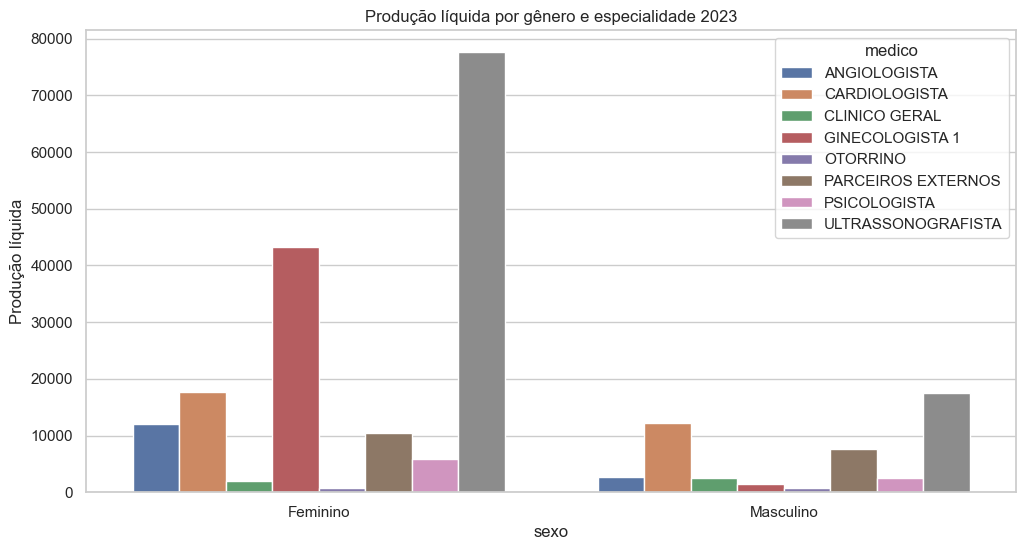

In [74]:
plt.figure(figsize = (12 , 6))
sns.barplot(data = prod_genero23 , x = 'sexo' , y = 'líquido' , hue = 'medico')

plt.title('Produção líquida por gênero e especialidade 2023')
plt.ylabel('Produção líquida')

plt.show()

#### Filtro ano de 2024

In [75]:
df_fin.head()

id amigo       sexo                 bairro       plano data atend  \
0  42512119   Feminino  JARDIM DAS MARGARIDAS  PARTICULAR 2023-01-03   
1  42510350   Feminino                 ITAPUÃ    PLANSERV 2023-01-03   
2  43189318   Feminino          BAIRRO DA PAZ  PARTICULAR 2023-01-05   
3  42510093  Masculino                 ITAPUÃ    PLANSERV 2023-01-05   
4  42512574   Feminino                   CAJI  PARTICULAR 2023-01-05   

  forma de pagamento              medico  \
0             Cartão  ULTRASSONOGRAFISTA   
1           PLANSERV  ULTRASSONOGRAFISTA   
2             Cartão  ULTRASSONOGRAFISTA   
3           Dinheiro  ULTRASSONOGRAFISTA   
4             Cartão  ULTRASSONOGRAFISTA   

                      procedimento/matmed  faturado  desconto  líquido  \
0           ULTRASSONOGRAFIA TRANSVAGINAL     90.00     2.286   87.714   
1  ULTRASSONOGRAFIA PARTES MOLES EM GERAL     34.72     0.000   34.720   
2     OBSTÉTRICA MORFOLÓGICA 2º TRIMESTRE    180.00     0.000  180.000   
3     ULTRASSONOGRAFIA PRÓSTATA ABDOMINAL     90.00     0.000   90.000   
4           ULTRASSONOGRAFIA TRANSVAGINAL     90.00     2.286   87.714   

   repasse executante  faturamento_clinica  \
0              88.857               87.714   
1              34.720               34.720   
2             180.000              180.000   
3              90.000               90.000   
4              88.857               87.714   

                                        regiao  
0                               Outras regiões  
1             Região de Itapuã e São Cristóvão  
2             Região de Itapuã e São Cristóvão  
3             Região de Itapuã e São Cristóvão  
4  Centro de Salvador e Regiões Circunvizinhas

In [76]:
dados_2024 = df_fin[df_fin['data atend'].dt.year == 2024].copy()
dados_2024['mes_ano']  = dados_2024['data atend'].dt.to_period('M')

In [77]:
prod_mens_2024 = dados_2024.groupby(['mes_ano' , 'medico'])['líquido'].sum().reset_index()
prod_mens_2024['mes_ano'] = prod_mens_2024['mes_ano'].astype(str)

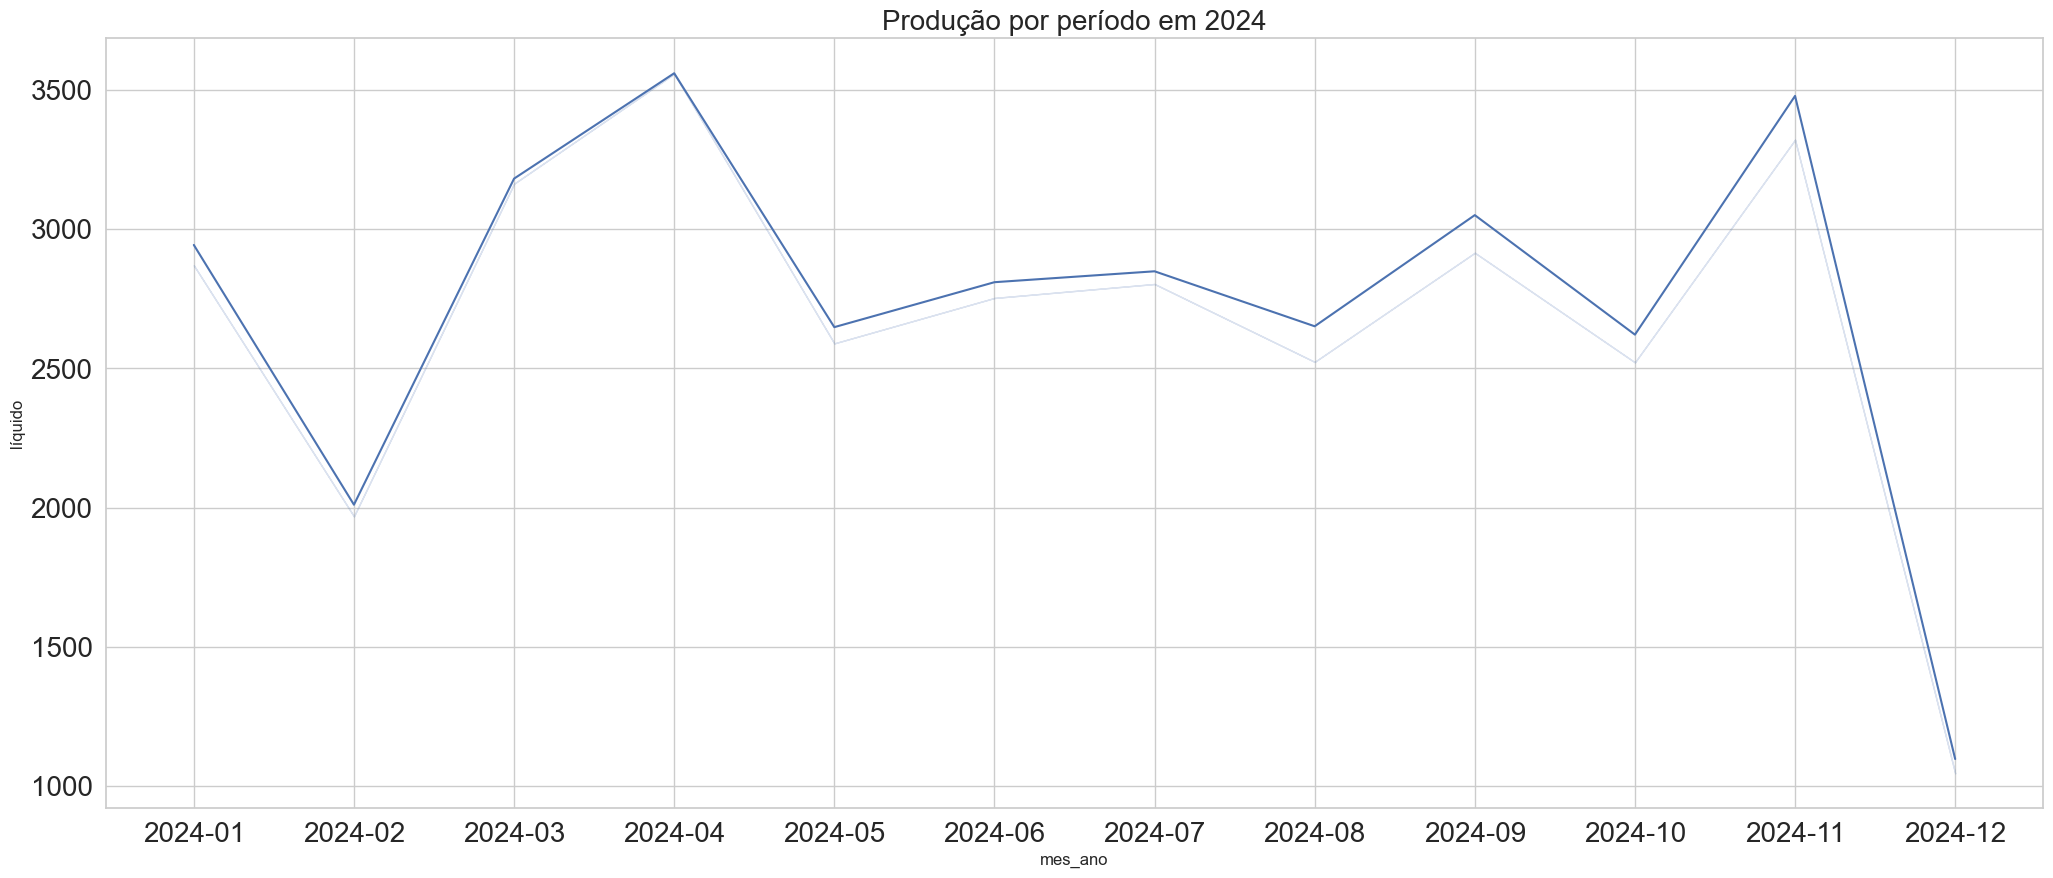

In [78]:
plt.figure(figsize = (25 , 10))
sns.lineplot(data = prod_mens_2024 , x = 'mes_ano' , y = 'líquido' , errorbar = ('ci' , 0))

plt.title('Produção por período em 2024', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

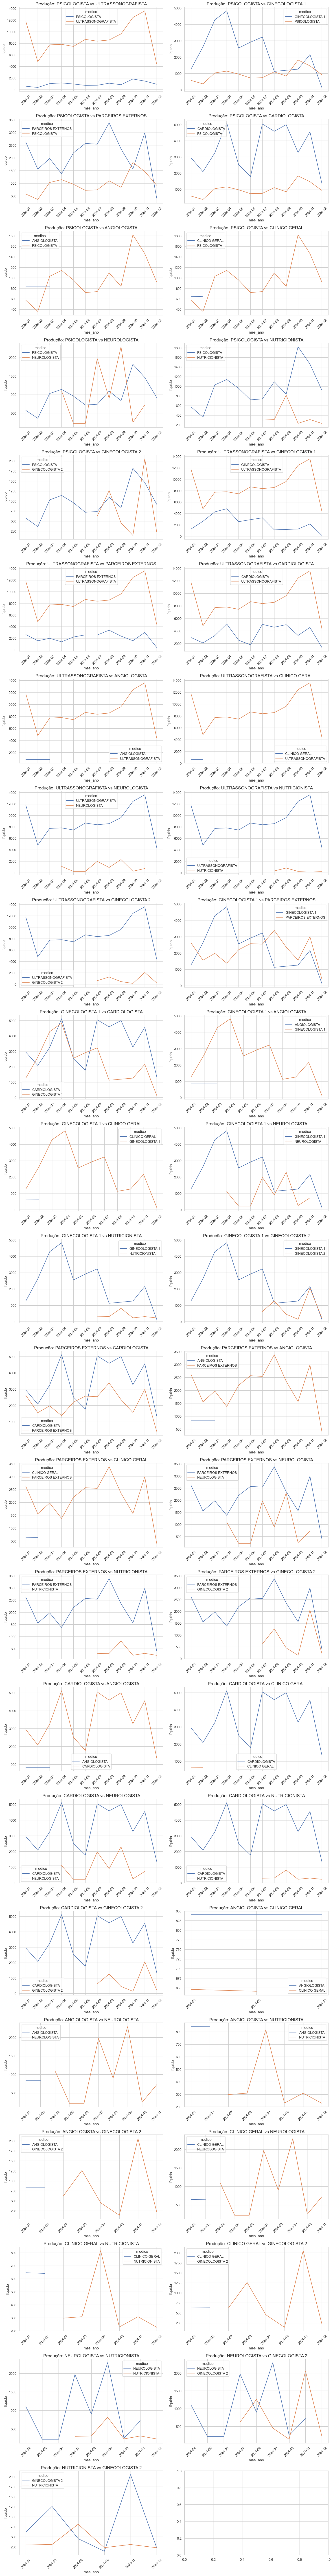

In [79]:
especialidades = dados_2024.medico.unique()
num_graficos = len(especialidades) * (len(especialidades) - 1) // 2  # Combinações únicas
linhas = (num_graficos + 1) // 2  # Duas colunas, então divide por 2

fig, ax = plt.subplots(linhas, 2, figsize=(15, linhas * 5))  # Ajusta o tamanho

idx = 0  # Índice para percorrer os subplots
for i, esp1 in enumerate(especialidades):
    for esp2 in especialidades[i+1:]:  # Evita repetição de combinações
        row, col = divmod(idx, 2)  # Calcula posição do subplot
        filtro = prod_mens_2024[prod_mens_2024['medico'].isin([esp1, esp2])]

        sns.lineplot(data=filtro, x='mes_ano', y='líquido', hue='medico', ax=ax[row, col], errorbar=('ci', 0))
        ax[row, col].set_title(f'Produção: {esp1} vs {esp2}', fontsize=14)
        ax[row, col].tick_params(axis='x', rotation=45)

        idx += 1  # Atualiza índice

plt.tight_layout()  # Ajusta o espaçamento entre os gráficos
plt.show()

In [80]:
prod_genero24 = dados_2024.copy().groupby(['sexo' , 'medico'])['líquido'].sum().reset_index()

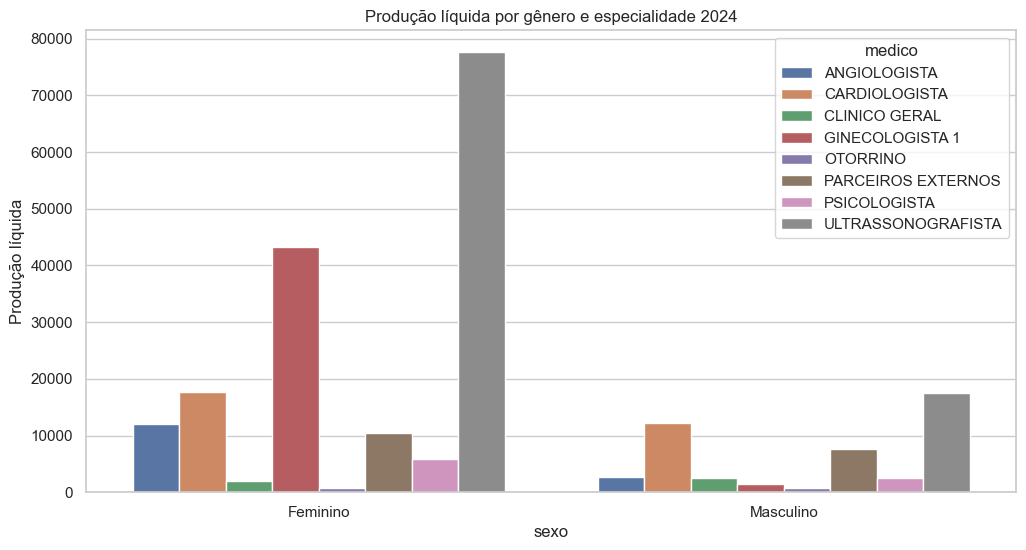

In [81]:
plt.figure(figsize = (12 ,6))
sns.barplot(data = prod_genero23 , x = 'sexo' , y= 'líquido' , hue = 'medico')

plt.title('Produção líquida por gênero e especialidade 2024')
plt.ylabel('Produção líquida')

plt.show()

## Etapa 4 Crisp-DM: Modelagem

### PREVISÃO DE FALTAS

#### Criando DF de historico dos pacientes

In [82]:
produtividade['status do agendamento'].value_counts()

status do agendamento
Finalizado    5875
Faltou        1163
Cancelado      242
Name: count, dtype: int64

In [83]:
repasse.head()

data atend  id amigo forma de pagamento              medico  \
0 2023-01-03  42512119             Cartão  ULTRASSONOGRAFISTA   
1 2023-01-03  42510350           PLANSERV  ULTRASSONOGRAFISTA   
2 2023-01-05  49663272           Dinheiro  ULTRASSONOGRAFISTA   
3 2023-01-05  49668596             Cartão  ULTRASSONOGRAFISTA   
4 2023-01-05  43189318             Cartão  ULTRASSONOGRAFISTA   

                      procedimento/matmed  faturado  desconto  líquido  \
0           ULTRASSONOGRAFIA TRANSVAGINAL     90.00     2.286   87.714   
1  ULTRASSONOGRAFIA PARTES MOLES EM GERAL     34.72     0.000   34.720   
2           ULTRASSONOGRAFIA ABDOME TOTAL     90.00     0.000   90.000   
3     ULTRASSONOGRAFIA PRÓSTATA ABDOMINAL     90.00     2.286   87.714   
4     OBSTÉTRICA MORFOLÓGICA 2º TRIMESTRE    180.00     0.000  180.000   

   repasse executante  
0              88.857  
1              34.720  
2              90.000  
3              88.857  
4             180.000

In [84]:
df_pacientes_fin = (
    produtividade[['hora do agendamento', 'medico', 'id amigo', 'tipo de atendimento', 'status do agendamento', 'forma de pagamento', 'idade']]
    .merge(pacientes[['sexo', 'plano', 'id amigo']], on='id amigo', how='left')
    .merge(repasse[['data atend', 'id amigo']], on='id amigo', how='left')
    .merge(df_fin[['regiao', 'id amigo']], on='id amigo', how='left')
    .assign(
        nao_compareceu=lambda df: df["status do agendamento"].isin(["Cancelou", "Faltou"]).astype(int),
        **{
            'hora do agendamento': lambda df: pd.to_datetime(df["hora do agendamento"], format="%H:%M").dt.time,
            'dia da semana': lambda df: df['data atend'].dt.dayofweek,
            'mes': lambda df: df['data atend'].dt.month
        }
    )
)
df_pacientes_fin.head()

hora do agendamento        medico  id amigo  \
0            16:30:00  PSICOLOGISTA  42510843   
1            16:30:00  PSICOLOGISTA  42510843   
2            16:30:00  PSICOLOGISTA  42510843   
3            16:30:00  PSICOLOGISTA  42510843   
4            16:30:00  PSICOLOGISTA  42510843   

                  tipo de atendimento status do agendamento  \
0  PACOTE DE PSICOLOGIA COM 8 SESSÕES                Faltou   
1  PACOTE DE PSICOLOGIA COM 8 SESSÕES                Faltou   
2  PACOTE DE PSICOLOGIA COM 8 SESSÕES                Faltou   
3  PACOTE DE PSICOLOGIA COM 8 SESSÕES                Faltou   
4  PACOTE DE PSICOLOGIA COM 8 SESSÕES                Faltou   

  forma de pagamento  idade      sexo       plano data atend  \
0             Cartão   65.0  Feminino  PARTICULAR 2024-03-13   
1             Cartão   65.0  Feminino  PARTICULAR 2024-03-13   
2             Cartão   65.0  Feminino  PARTICULAR 2024-03-13   
3             Cartão   65.0  Feminino  PARTICULAR 2024-03-13   
4             Cartão   65.0  Feminino  PARTICULAR 2024-03-13   

                             regiao  nao_compareceu  dia da semana  mes  
0  Região de Itapuã e São Cristóvão               1            2.0  3.0  
1  Região de Itapuã e São Cristóvão               1            2.0  3.0  
2  Região de Itapuã e São Cristóvão               1            2.0  3.0  
3  Região de Itapuã e São Cristóvão               1            2.0  3.0  
4  Região de Itapuã e São Cristóvão               1            2.0  3.0

In [85]:
def turno(horario):
    try:
        if pd.isna(horario):
            return None
        if horario.hour < 12:
            return "matutino"
        return "vespertino"
    except AttributeError:
        return None



In [86]:
df_pacientes_fin["turno"] = df_pacientes_fin["hora do agendamento"].apply(turno)
historico_faltas = df_pacientes_fin.groupby("id amigo")["nao_compareceu"].cumsum()
df_pacientes_fin["historico_faltas"] = historico_faltas

df_pacientes_fin.head()

hora do agendamento        medico  id amigo  \
0            16:30:00  PSICOLOGISTA  42510843   
1            16:30:00  PSICOLOGISTA  42510843   
2            16:30:00  PSICOLOGISTA  42510843   
3            16:30:00  PSICOLOGISTA  42510843   
4            16:30:00  PSICOLOGISTA  42510843   

                  tipo de atendimento status do agendamento  \
0  PACOTE DE PSICOLOGIA COM 8 SESSÕES                Faltou   
1  PACOTE DE PSICOLOGIA COM 8 SESSÕES                Faltou   
2  PACOTE DE PSICOLOGIA COM 8 SESSÕES                Faltou   
3  PACOTE DE PSICOLOGIA COM 8 SESSÕES                Faltou   
4  PACOTE DE PSICOLOGIA COM 8 SESSÕES                Faltou   

  forma de pagamento  idade      sexo       plano data atend  \
0             Cartão   65.0  Feminino  PARTICULAR 2024-03-13   
1             Cartão   65.0  Feminino  PARTICULAR 2024-03-13   
2             Cartão   65.0  Feminino  PARTICULAR 2024-03-13   
3             Cartão   65.0  Feminino  PARTICULAR 2024-03-13   
4             Cartão   65.0  Feminino  PARTICULAR 2024-03-13   

                             regiao  nao_compareceu  dia da semana  mes  \
0  Região de Itapuã e São Cristóvão               1            2.0  3.0   
1  Região de Itapuã e São Cristóvão               1            2.0  3.0   
2  Região de Itapuã e São Cristóvão               1            2.0  3.0   
3  Região de Itapuã e São Cristóvão               1            2.0  3.0   
4  Região de Itapuã e São Cristóvão               1            2.0  3.0   

        turno  historico_faltas  
0  vespertino                 1  
1  vespertino                 2  
2  vespertino                 3  
3  vespertino                 4  
4  vespertino                 5

#### Separando DF em treino e teste

In [87]:
X = df_pacientes_fin.drop(columns = ['data atend' ,'hora do agendamento' , 'id amigo' , 'nao_compareceu' , 'status do agendamento'])
y = df_pacientes_fin['nao_compareceu']

In [88]:
X_train , X_test , y_train , y_test = train_test_split(X , y , random_state= 21 , test_size= 0.2)

In [89]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

#### Buscando melhor árvore

In [90]:
ccp_alphas = np.linspace(0, 0.02, 10)  # Testando de 0 a 0.02 com 10 valores

# Listas para armazenar métricas
accuracies = []
f1_scores = []
auc_rocs = []

for alpha in ccp_alphas:
    # Criando a árvore de decisão com poda
    clf = DecisionTreeClassifier(random_state=21, ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    
    # Previsões no conjunto de teste
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]  # Probabilidade para classe 1 (faltante)

    # Calculando métricas
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # Salvando os resultados
    accuracies.append(acc)
    f1_scores.append(f1)
    auc_rocs.append(auc)

# Criando um DataFrame com os resultados
df_results = pd.DataFrame({
    'ccp_alpha': ccp_alphas,
    'accuracy': accuracies,
    'f1_score': f1_scores,
    'auc_roc': auc_rocs
})

# Exibindo os melhores valores
df_results.sort_values(by='auc_roc', ascending=False)

ccp_alpha  accuracy  f1_score   auc_roc
0   0.000000  0.998448  0.993040  0.995545
1   0.002222  0.963109  0.828445  0.967521
2   0.004444  0.956402  0.795732  0.951862
3   0.006667  0.948969  0.743748  0.830873
4   0.008889  0.943488  0.704450  0.824724
5   0.011111  0.904395  0.493772  0.692958
6   0.013333  0.904395  0.493772  0.692958
7   0.015556  0.895110  0.415889  0.649966
8   0.017778  0.895110  0.415889  0.649966
9   0.020000  0.895110  0.415889  0.649966

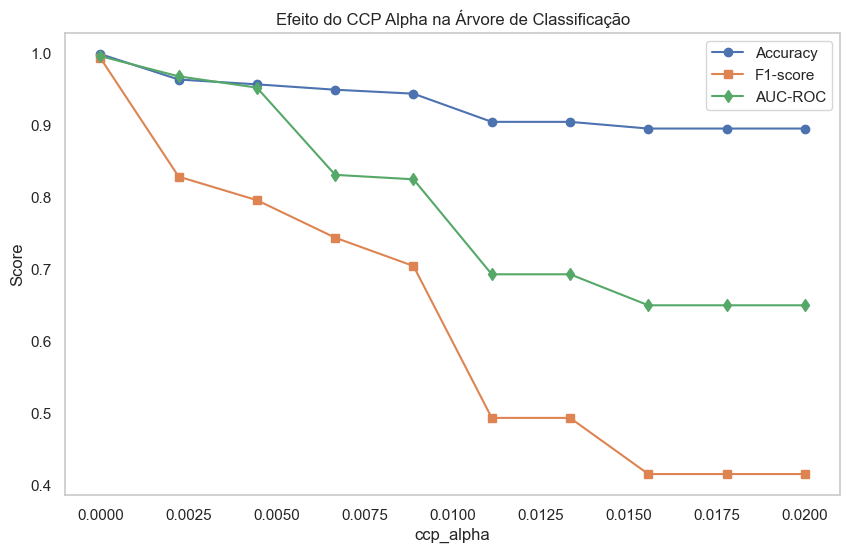

In [91]:
plt.figure(figsize=(10, 6))

plt.plot(ccp_alphas, accuracies, marker='o', label="Accuracy")
plt.plot(ccp_alphas, f1_scores, marker='s', label="F1-score")
plt.plot(ccp_alphas, auc_rocs, marker='d', label="AUC-ROC")

plt.xlabel("ccp_alpha")
plt.ylabel("Score")
plt.title("Efeito do CCP Alpha na Árvore de Classificação")
plt.legend()
plt.grid()
plt.show()


#### Melhor árvore de decisão

In [92]:
best_alpha = df_results.loc[df_results['auc_roc'].idxmax(), 'ccp_alpha']

clf_final = DecisionTreeClassifier(random_state=21, ccp_alpha=best_alpha)
clf_final.fit(X_train, y_train)


DecisionTreeClassifier(random_state=21)

In [94]:
importances = clf_final.feature_importances_
feature_names = X_train.columns

df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
df_importances = df_importances.sort_values(by='Importance', ascending=False)

In [95]:
df_importances.head(30)

Feature  Importance
3                                    historico_faltas    0.466932
68                        forma de pagamento_Pendente    0.141005
65                          forma de pagamento_Faltou    0.074460
66                       forma de pagamento_PARATODOS    0.051377
34                            tipo de atendimento_ECG    0.048979
13                                medico_PSICOLOGISTA    0.044917
0                                               idade    0.044246
2                                                 mes    0.010658
80                              regiao_Outras regiões    0.009875
81            regiao_Região de Itapuã e São Cristóvão    0.009350
76                                   plano_PARTICULAR    0.008941
49  tipo de atendimento_PACOTE DE PSICOLOGIA COM 8...    0.008302
32                       tipo de atendimento_CURATIVO    0.008162
41                           tipo de atendimento_MAPA    0.006262
1                                       dia da semana    0.006259
56                        tipo de atendimento_RETORNO    0.006117
83                                     turno_matutino    0.005328
50  tipo de atendimento_PACOTE PSICOLOGIA COM 4 SE...    0.005245
84                                   turno_vespertino    0.005245
5                                medico_CARDIOLOGISTA    0.004727
61                          forma de pagamento_Cartão    0.004394
64                        forma de pagamento_Dinheiro    0.004310
36                 tipo de atendimento_ECOCARDIOGRAMA    0.002685
59                          forma de pagamento_ASTEBA    0.001990
58                          forma de pagamento_ASSEBA    0.001936
28          tipo de atendimento_CONSULTA GINECOLÓGICA    0.001482
6                                medico_CLINICO GERAL    0.001391
14                          medico_ULTRASSONOGRAFISTA    0.001203
7                              medico_GINECOLOGISTA 1    0.001185
8                              medico_GINECOLOGISTA 2    0.001069

#### Avaliação do modelo

##### Matriz de confusão

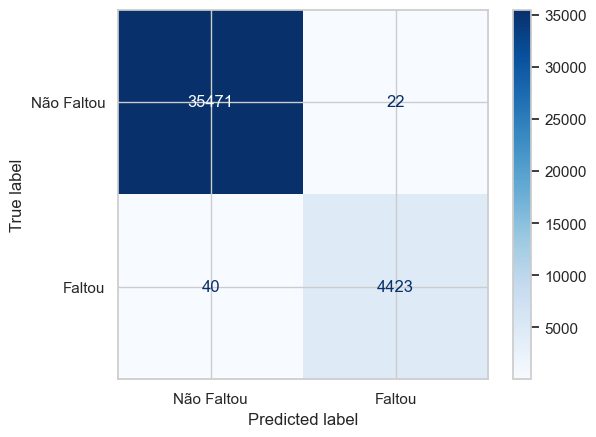

In [96]:
y_pred = clf_final.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Não Faltou", "Faltou"])
disp.plot(cmap="Blues")
plt.show()

**Interpretação**

- Verdadeiros Positivos (TP = 4.417) → Pacientes que realmente faltaram e foram corretamente classificados como faltantes.

- Verdadeiros Negativos (TN = 35.471) → Pacientes que compareceram e foram corretamente classificados como presentes.

- Falsos Positivos (FP = 22) → Pacientes que compareceram, mas o modelo previu que faltariam.

- Falsos Negativos (FN = 46) → Pacientes que faltaram, mas o modelo previu que compareceriam.

#### Métricas do modelo

In [97]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Acurácia: 0.9984
Precisão: 0.9951
Recall: 0.9910
F1-score: 0.9930


### TABELA RFV

**RFV** significa recência, frequência, valor e é utilizado para segmentação de clientes baseado no comportamento de compras dos clientes e agrupa eles em clusters parecidos. Utilizando esse tipo de agrupamento podemos realizar ações de marketing e CRM melhores direcionadas, ajudando assim na personalização do conteúdo e até a retenção de clientes.

Para cada cliente é preciso calcular cada uma das componentes abaixo:

- Recência (R): Quantidade de dias desde a última compra.
- Frequência (F): Quantidade total de compras no período.
- Valor (V): Total de dinheiro gasto nas compras do período.

E é isso que iremos fazer abaixo.

#### Tabela de Recencia
- Quantos dias faz que o cliente fez a sua última compra?

In [98]:
print ('Data do atendimento mais antigo na base : {}'.format(df_fin['data atend'].min()))
print ('Data do atendimento mais recente na base : {}'.format(df_fin['data atend'].max()))

Data do atendimento mais antigo na base : 2023-01-03 00:00:00
Data do atendimento mais recente na base : 2024-12-27 00:00:00


In [99]:
dia_atual = datetime(2025, 1, 3)
print(dia_atual)

2025-01-03 00:00:00


In [100]:
df_recencia = df_fin.groupby(by='id amigo',
                                 as_index=False)['data atend'].max()
df_recencia.columns = ['id amigo', 'ultimo atend']
df_recencia['Recencia'] = df_recencia['ultimo atend'].apply(
    lambda x:(dia_atual - x).days)
df_recencia.drop('ultimo atend' ,axis = 1, inplace = True)

In [101]:
df_recencia.head()

id amigo  Recencia
0  42505695        77
1  42505715       469
2  42505771       546
3  42505787       255
4  42505911        17

#### Tabela Frequência
- Número de procedimentos realizados pelo paciente

In [102]:
df_frequencia = df_fin.groupby('id amigo').size().reset_index(name='Frequencia')
df_frequencia.head()

id amigo  Frequencia
0  42505695           2
1  42505715           4
2  42505771           1
3  42505787           2
4  42505911           4

#### Tabela de Valor

- Valor gasto por cada cliente

In [103]:
df_valor = df_fin[['id amigo', 'faturado'
                       ]].groupby('id amigo').sum().reset_index()
df_valor.columns = ['id amigo', 'Valor']
df_valor.head()

id amigo   Valor
0  42505695  190.00
1  42505715  380.00
2  42505771   32.74
3  42505787   88.00
4  42505911  515.00

#### Criando a tabela RFV

In [104]:
df_rf = df_recencia.merge(df_frequencia , on = 'id amigo')
df_RFV = df_rf.merge(df_valor, on='id amigo')
df_RFV.set_index('id amigo', inplace=True)
df_RFV.head()

Recencia  Frequencia   Valor
id amigo                              
42505695        77           2  190.00
42505715       469           4  380.00
42505771       546           1   32.74
42505787       255           2   88.00
42505911        17           4  515.00

#### Segmentando clientes

Um jeito de segmentar os clientes é criando quartis para cada componente do RFV, sendo que o melhor quartil é chamado de 'A', o segundo melhor quartil de 'B', o terceiro melhor de 'C' e o pior de 'D'. O melhor e o pior depende da componente. Por exemplo, quanto menor a recência melhor é o cliente (pois ele comprou com a gente tem pouco tempo) logo o menor quartil seria classificado como 'A', já pra componente frêquencia a lógica se inverte, ou seja, quanto maior a frêquencia do cliente comprar com a gente, melhor ele/a é, logo, o maior quartil recebe a letra 'A'.

Se estivermos interessados em mais ou menos classes, basta aumentarmos ou diminuir o número de quantils pra cada componente.

In [105]:
quartis = df_RFV.quantile(q=[0.25, 0.5, 0.75])
quartis.to_dict()

{'Recencia': {0.25: 147.75, 0.5: 319.0, 0.75: 512.0},
 'Frequencia': {0.25: 1.0, 0.5: 1.0, 0.75: 3.0},
 'Valor': {0.25: 100.0, 0.5: 150.0, 0.75: 295.0}}

In [106]:
def recencia_class(x, r, q_dict):
    """Classifica como melhor o menor quartil 
       x = valor da linha,
       r = recencia,
       q_dict = quartil dicionario   
    """
    if x <= q_dict[r][0.25]:
        return 'A'
    elif x <= q_dict[r][0.50]:
        return 'B'
    elif x <= q_dict[r][0.75]:
        return 'C'
    else:
        return 'D'


def freq_val_class(x, fv, q_dict):
    """Classifica como melhor o maior quartil 
       x = valor da linha,
       fv = frequencia ou valor,
       q_dict = quartil dicionario   
    """
    if x <= q_dict[fv][0.25]:
        return 'D'
    elif x <= q_dict[fv][0.50]:
        return 'C'
    elif x <= q_dict[fv][0.75]:
        return 'B'
    else:
        return 'A'

df_RFV['R_quartil'] = df_RFV['Recencia'].apply(recencia_class,
                                                args=('Recencia', quartis))
df_RFV['F_quartil'] = df_RFV['Frequencia'].apply(freq_val_class,
                                                  args=('Frequencia', quartis))
df_RFV['V_quartil'] = df_RFV['Valor'].apply(freq_val_class,
                                             args=('Valor', quartis))

In [107]:
df_RFV.head()

df_RFV['RFV_Score'] = (df_RFV.R_quartil + df_RFV.F_quartil +
                       df_RFV.V_quartil)
df_RFV.head()

Recencia  Frequencia   Valor R_quartil F_quartil V_quartil RFV_Score
id amigo                                                                      
42505695        77           2  190.00         A         B         B       ABB
42505715       469           4  380.00         C         A         A       CAA
42505771       546           1   32.74         D         D         D       DDD
42505787       255           2   88.00         B         B         D       BBD
42505911        17           4  515.00         A         A         A       AAA

In [108]:
df_RFV['RFV_Score'].value_counts()

RFV_Score
CDD    187
DDD    185
BDD    170
ADD    137
AAA    104
ABB     71
ABA     68
DBB     68
DDC     64
BAA     63
BBB     59
CBA     54
CAA     54
BBA     51
CBB     51
CDC     51
DDB     50
ADB     45
BDC     44
BDB     43
DBA     39
CDB     34
DBC     31
DAA     24
BBC     24
CBC     23
ADC     18
BAB     15
AAB     13
ABC     13
DAB     12
CAB     11
BBD     10
CBD     10
BDA      7
ADA      7
ABD      7
CDA      6
DBD      5
DDA      4
Name: count, dtype: int64

In [109]:
variaveis = df_RFV.iloc[: , :-1].columns.values
variaveis_quant = df_RFV.iloc[: , :3].columns.values
variaveis_cat = df_RFV.iloc[:, 3:-1].columns.values

In [110]:
df_pad = pd.DataFrame(StandardScaler().fit_transform(df_RFV[variaveis_quant]) , columns = df_RFV[variaveis_quant].columns)
df_pad[variaveis_cat] = df_RFV[variaveis_cat].values
df_pad.head()

Recencia  Frequencia     Valor R_quartil F_quartil V_quartil
0 -1.243341   -0.067420 -0.190877         A         B         B
1  0.627176    0.904629  0.657664         C         A         A
2  0.994599   -0.553444 -0.893202         D         D         D
3 -0.393974   -0.067420 -0.646410         B         B         D
4 -1.529645    0.904629  1.260575         A         A         A

In [111]:
df_rfv_dummies = pd.get_dummies(df_pad[variaveis].dropna() , columns = variaveis_cat , dtype = int)
df_rfv_dummies.head()

Recencia  Frequencia     Valor  R_quartil_A  R_quartil_B  R_quartil_C  \
0 -1.243341   -0.067420 -0.190877            1            0            0   
1  0.627176    0.904629  0.657664            0            0            1   
2  0.994599   -0.553444 -0.893202            0            0            0   
3 -0.393974   -0.067420 -0.646410            0            1            0   
4 -1.529645    0.904629  1.260575            1            0            0   

   R_quartil_D  F_quartil_A  F_quartil_B  F_quartil_D  V_quartil_A  \
0            0            0            1            0            0   
1            0            1            0            0            1   
2            1            0            0            1            0   
3            0            0            1            0            0   
4            0            1            0            0            1   

   V_quartil_B  V_quartil_C  V_quartil_D  
0            1            0            0  
1            0            0            0  
2            0            0            1  
3            0            0            1  
4            0            0            0

In [112]:
colunas_categoricas = set(df_rfv_dummies.iloc[: , 3:].columns)

In [113]:
vars_cat = [col in colunas_categoricas for col in df_rfv_dummies.columns]
distancia_gower = gower_matrix(df_rfv_dummies, cat_features=vars_cat)
gdv = squareform(distancia_gower, force='tovector')

In [114]:
Z = linkage(gdv , method = 'complete')
Z_df = pd.DataFrame(Z , columns = ['ind1' , 'ind2' , 'dist' , 'n'])
Z_df.head()

ind1    ind2  dist    n
0    55.0   486.0   0.0  2.0
1   135.0  1435.0   0.0  2.0
2     8.0  1404.0   0.0  2.0
3  1409.0  1934.0   0.0  3.0
4  1425.0  1427.0   0.0  2.0

In [115]:
df_RFV['4 grupos'] = fcluster(Z , 4 , criterion = 'maxclust')
df_RFV['5 grupos'] = fcluster(Z , 5 , criterion = 'maxclust')

In [116]:
print(df_RFV['4 grupos'].value_counts())
print(df_RFV['5 grupos'].value_counts())

4 grupos
2    908
3    446
1    296
4    282
Name: count, dtype: int64
5 grupos
3    542
4    446
2    366
1    296
5    282
Name: count, dtype: int64


In [117]:
df_RFV['index'] = df_rfv_dummies.index
df_RFV_fin = df_RFV.merge(df_rfv_dummies.reset_index() , on = 'index' , how = 'left')
df_RFV_fin = df_RFV.reset_index().merge(df_rfv_dummies.reset_index() , on = 'index' , how = 'left')

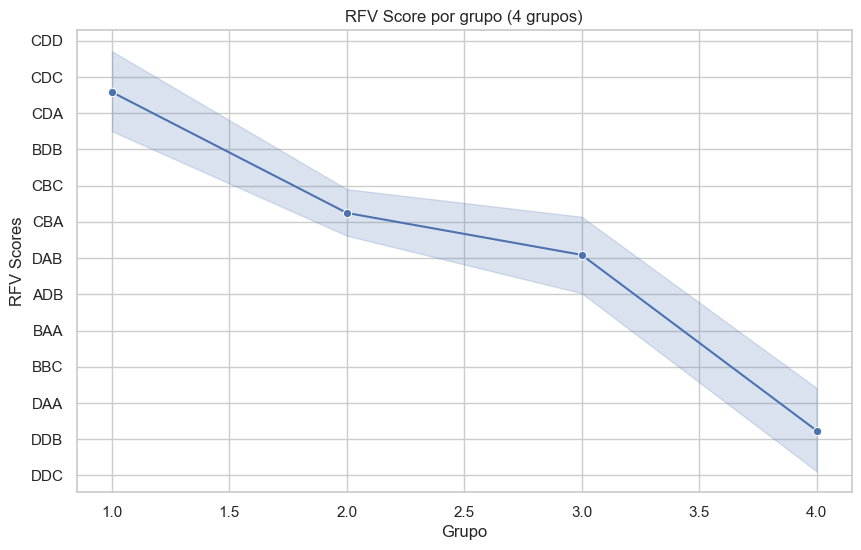

In [118]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='4 grupos', y='RFV_Score', data=df_RFV_fin, marker='o')
plt.title('RFV Score por grupo (4 grupos)')
plt.xlabel('Grupo')
plt.ylabel('RFV Scores')

plt.savefig('output/RFV score 4 grupos.png', dpi=300, bbox_inches='tight')

plt.show()

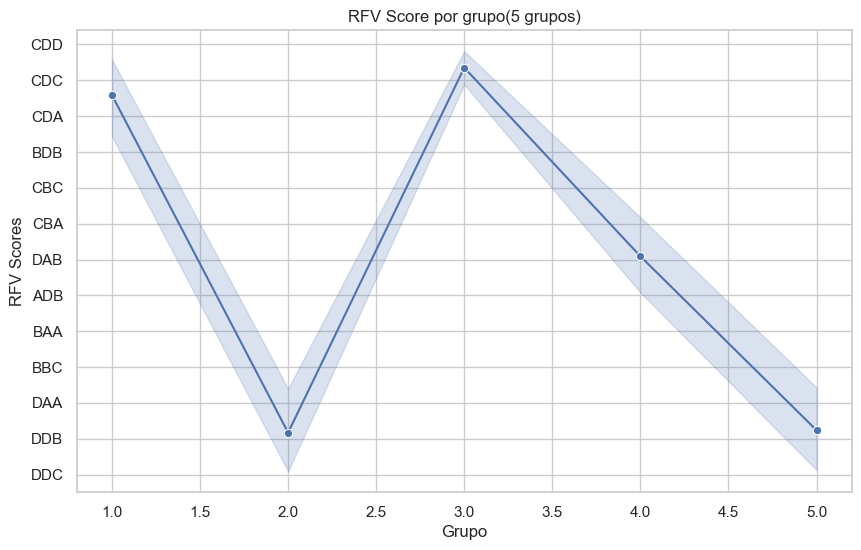

In [119]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='5 grupos', y='RFV_Score', data=df_RFV_fin, marker='o')
plt.title('RFV Score por grupo(5 grupos)')
plt.xlabel('Grupo')
plt.ylabel('RFV Scores')

plt.savefig('output/RFV Score 5 grupos.png', dpi=300, bbox_inches='tight')

plt.show()



In [120]:
df_RFV.head()

Recencia  Frequencia   Valor R_quartil F_quartil V_quartil  \
id amigo                                                               
42505695        77           2  190.00         A         B         B   
42505715       469           4  380.00         C         A         A   
42505771       546           1   32.74         D         D         D   
42505787       255           2   88.00         B         B         D   
42505911        17           4  515.00         A         A         A   

         RFV_Score  4 grupos  5 grupos  index  
id amigo                                       
42505695       ABB         2         2      0  
42505715       CAA         1         1      1  
42505771       DDD         3         4      2  
42505787       BBD         4         5      3  
42505911       AAA         1         1      4

In [121]:
df_RFV.drop(columns = ['R_quartil' ,'F_quartil' , 'V_quartil' , '4 grupos' , 'index'] , inplace = True)

In [122]:
df_RFV.to_excel('output/tabela rfv.xlsx', index=True) # Salvando arquivo em excel

##### Estratégia de Segmentação RFV para Comunicação Direcionada


A análise RFV (Recência, Frequência e Valor) foi utilizada para segmentar os clientes em 4 ou 5 grupos, permitindo uma comunicação mais eficiente e personalizada. Com base nessa segmentação, foram definidas abordagens estratégicas específicas para cada grupo, visando maximizar o engajamento e a fidelização dos clientes:

- **Grupo 4 ou 5 (Clientes mais engajados e de alto valor):**
  - **Ações:** Enviar mensagens de agradecimento e reconhecimento pela fidelidade. Oferecer benefícios exclusivos, como descontos personalizados ou acesso antecipado a novidades. Manter um relacionamento próximo, destacando o valor da parceria.
  - **Objetivo:** Reforçar a lealdade e incentivar a continuidade do engajamento.

- **Grupo 3 (Clientes recorrentes, mas com menor recência):**
  - **Ações:** Enviar lembretes sobre serviços disponíveis e vantagens de manter a recorrência. Oferecer promoções ou ofertas especiais para estimular um novo contato.
  - **Objetivo:** Reativar o interesse e aumentar a frequência de compras.

- **Grupo 2 (Clientes que compraram há mais tempo, mas com bom valor gasto):**
  - **Ações:** Realizar campanhas de reativação, destacando novidades ou benefícios de retornar. Oferecer cupons de desconto ou ofertas personalizadas para incentivar uma nova compra.
  - **Objetivo:** Reengajar clientes com potencial de retorno.

- **Grupo 1 (Clientes pouco engajados ou de baixo valor):**
  - **Ações:** Enviar mensagens informativas sobre os serviços, buscando despertar interesse. Oferecer ofertas de teste ou consultas gratuitas para aumentar o engajamento inicial.
  - **Objetivo:** Atrair a atenção e converter clientes em compradores ativos.

Para implementar essa estratégia de forma escalável, estou desenvolvendo um script de automação via WhatsApp, que permitirá a personalização das mensagens conforme a segmentação RFV. O objetivo é garantir uma comunicação eficiente e direcionada, adaptando o conteúdo às necessidades de cada grupo.

O projeto está em fase de desenvolvimento e pode ser acessado pelo link abaixo:

[GitHub - Envio de Mensagens WhatsApp](https://github.com/GabrielAbiye/Envio-de-mensagens-wpp.git)

Atualmente, o script está passando por ajustes, mas a ideia é que ele funcione de maneira geral, permitindo a automação do envio de mensagens com base na segmentação RFV. Estou trabalhando na adaptação dos argumentos e na otimização do código para garantir um desempenho eficiente.


### PREVISÃO DE FATURAMENTO 2025

In [123]:
df_fin.head()

id amigo       sexo                 bairro       plano data atend  \
0  42512119   Feminino  JARDIM DAS MARGARIDAS  PARTICULAR 2023-01-03   
1  42510350   Feminino                 ITAPUÃ    PLANSERV 2023-01-03   
2  43189318   Feminino          BAIRRO DA PAZ  PARTICULAR 2023-01-05   
3  42510093  Masculino                 ITAPUÃ    PLANSERV 2023-01-05   
4  42512574   Feminino                   CAJI  PARTICULAR 2023-01-05   

  forma de pagamento              medico  \
0             Cartão  ULTRASSONOGRAFISTA   
1           PLANSERV  ULTRASSONOGRAFISTA   
2             Cartão  ULTRASSONOGRAFISTA   
3           Dinheiro  ULTRASSONOGRAFISTA   
4             Cartão  ULTRASSONOGRAFISTA   

                      procedimento/matmed  faturado  desconto  líquido  \
0           ULTRASSONOGRAFIA TRANSVAGINAL     90.00     2.286   87.714   
1  ULTRASSONOGRAFIA PARTES MOLES EM GERAL     34.72     0.000   34.720   
2     OBSTÉTRICA MORFOLÓGICA 2º TRIMESTRE    180.00     0.000  180.000   
3     ULTRASSONOGRAFIA PRÓSTATA ABDOMINAL     90.00     0.000   90.000   
4           ULTRASSONOGRAFIA TRANSVAGINAL     90.00     2.286   87.714   

   repasse executante  faturamento_clinica  \
0              88.857               87.714   
1              34.720               34.720   
2             180.000              180.000   
3              90.000               90.000   
4              88.857               87.714   

                                        regiao  
0                               Outras regiões  
1             Região de Itapuã e São Cristóvão  
2             Região de Itapuã e São Cristóvão  
3             Região de Itapuã e São Cristóvão  
4  Centro de Salvador e Regiões Circunvizinhas

In [124]:
# Converter a coluna data_atend para datetime
df_fin.reset_index(inplace = True)
df_fin['data atend'] = pd.to_datetime(df_fin['data atend'])

# Agrupar por mês e calcular o faturamento total
faturamento_mensal = df_fin.groupby(pd.Grouper(key='data atend', freq='M'))['faturamento_clinica'].sum().reset_index()

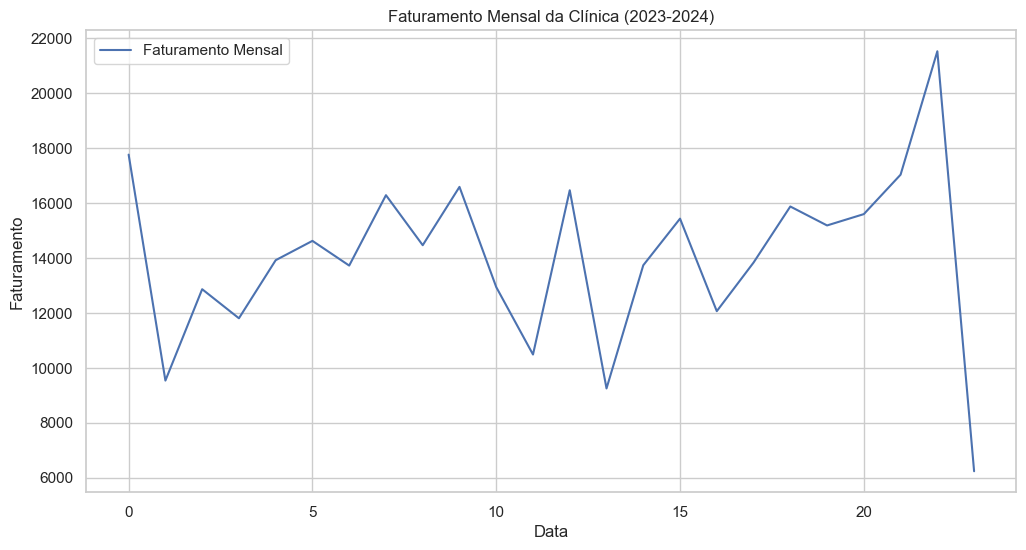

In [125]:
plt.figure(figsize=(12, 6))
plt.plot(faturamento_mensal.index, faturamento_mensal['faturamento_clinica'], label='Faturamento Mensal')
plt.title('Faturamento Mensal da Clínica (2023-2024)')
plt.xlabel('Data')
plt.ylabel('Faturamento')
plt.legend()
plt.show()

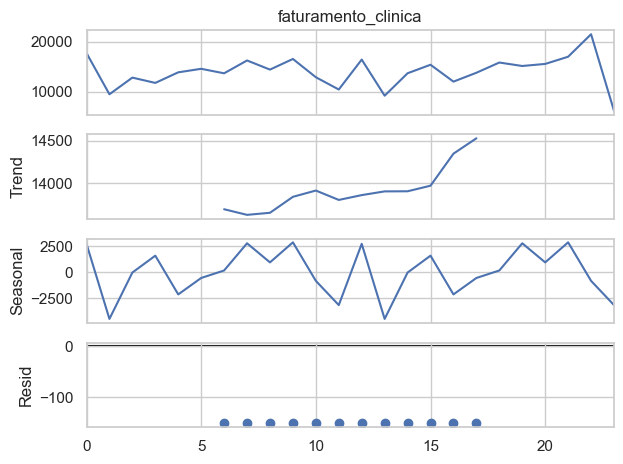

In [126]:
# Decompor a série temporal para identificar tendência e sazonalidade
decomposicao = seasonal_decompose(faturamento_mensal['faturamento_clinica'], model='additive', period=12)
decomposicao.plot()
plt.show()

<Figure size 1200x600 with 0 Axes>

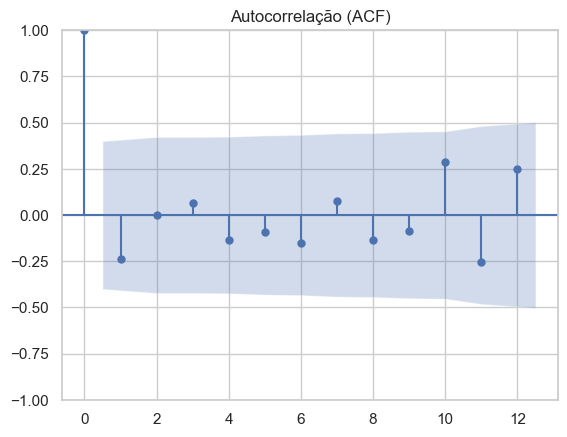

In [127]:
# ACF e PACF para identificar parâmetros do SARIMAX
plt.figure(figsize=(12, 6))
plot_acf(faturamento_mensal['faturamento_clinica'], lags=12)
plt.title('Autocorrelação (ACF)')
plt.show()

<Figure size 1200x600 with 0 Axes>

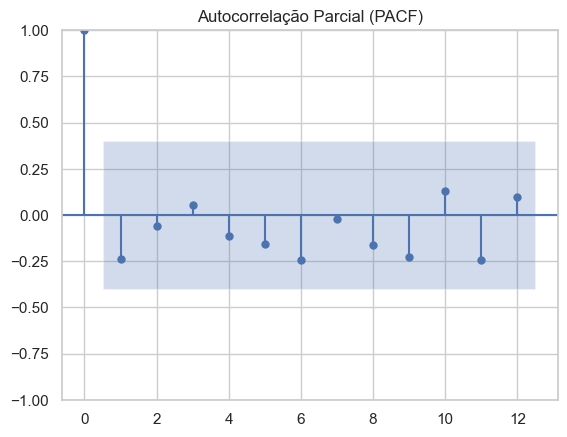

In [128]:
plt.figure(figsize=(12, 6))
plot_pacf(faturamento_mensal['faturamento_clinica'], lags=12)  # Ajustado para lags=12
plt.title('Autocorrelação Parcial (PACF)')

plt.show()

In [129]:
modelo = SARIMAX(
    faturamento_mensal['faturamento_clinica'],
    order=(1, 1, 1),  # (p, d, q)
    seasonal_order=(1, 1, 1, 12)  # (P, D, Q, s) com s=12 para sazonalidade anual
)
resultado = modelo.fit(disp=False)

# Resumo do modelo
resultado.summary()

C:\Users\g_abi\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                faturamento_clinica   No. Observations:                   24
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -106.244
Date:                            Fri, 28 Mar 2025   AIC                            222.489
Time:                                    19:57:08   BIC                            224.478
Sample:                                         0   HQIC                           221.234
                                             - 24                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6274      1.331     -0.471      0.637      -3.236       1.981
ma.L1         -0.7835      1.684     -0.465      0.642      -4.085       2.518
ar.S.L12      -0.9919      0.060    -16.431      0.000      -1.110      -0.874
ma.S.L12       0.3312      1.292      0.256      0.798      -2.201       2.864
sigma2      1.166e+07   1.05e-07   1.11e+14      0.000    1.17e+07    1.17e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                 0.41
Prob(Q):                              0.44   Prob(JB):                         0.82
Heteroskedasticity (H):               4.25   Skew:                            -0.47
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.14e+30. Standard errors may be unstable.
"""

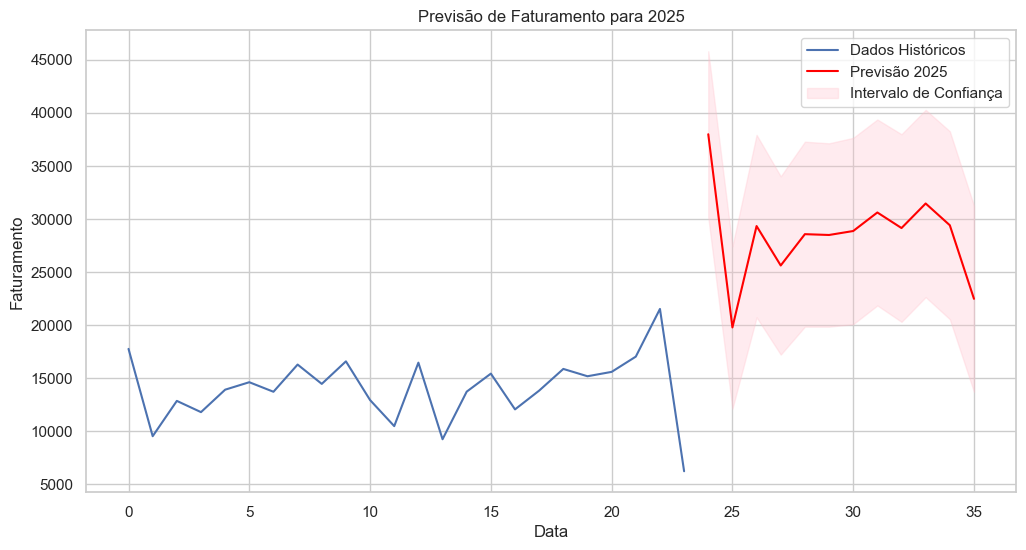

In [130]:
previsao = resultado.get_forecast(steps=12)
previsao_media = previsao.predicted_mean
intervalo_confianca = previsao.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(faturamento_mensal.index, faturamento_mensal['faturamento_clinica'], label='Dados Históricos')
plt.plot(previsao_media.index, previsao_media, label='Previsão 2025', color='red')
plt.fill_between(
    intervalo_confianca.index,
    intervalo_confianca.iloc[:, 0],
    intervalo_confianca.iloc[:, 1],
    color='pink', alpha=0.3, label='Intervalo de Confiança'
)
plt.title('Previsão de Faturamento para 2025')
plt.xlabel('Data')
plt.ylabel('Faturamento')
plt.legend()

plt.savefig('output/Previsão de faturamento 2025.png', dpi=300, bbox_inches='tight')

plt.show()

In [132]:
print(previsao_media.round(2))

24    37975.88
25    19781.08
26    29328.82
27    25616.32
28    28565.63
29    28488.65
30    28861.84
31    30607.76
32    29141.93
33    31453.92
34    29404.19
35    22476.65
Name: predicted_mean, dtype: float64


In [133]:
df_cenarios = pd.DataFrame({
    "Data": previsao_media.index,
    "Cenário Ruim": intervalo_confianca.iloc[:, 0],  # Limite inferior
    "Cenário Normal": previsao_media,                # Previsão central
    "Cenário Ótimo": intervalo_confianca.iloc[:, 1]  # Limite superior
})


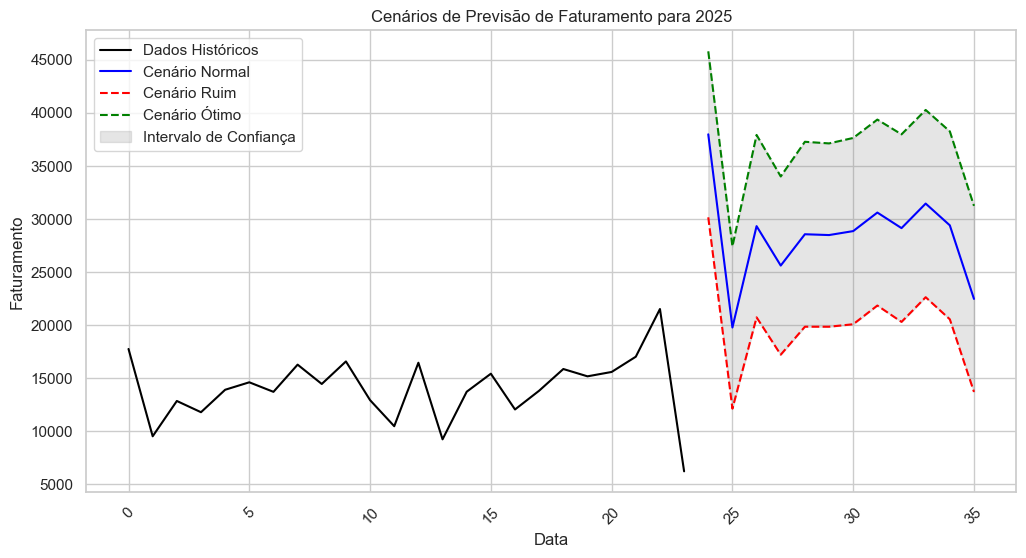

In [134]:
plt.figure(figsize=(12, 6))

# Dados históricos
plt.plot(faturamento_mensal.index, faturamento_mensal['faturamento_clinica'], label='Dados Históricos', color='black')

# Cenários
plt.plot(df_cenarios["Data"], df_cenarios["Cenário Normal"], label="Cenário Normal", color="blue")
plt.plot(df_cenarios["Data"], df_cenarios["Cenário Ruim"], linestyle="dashed", color="red", label="Cenário Ruim")
plt.plot(df_cenarios["Data"], df_cenarios["Cenário Ótimo"], linestyle="dashed", color="green", label="Cenário Ótimo")

# Sombreamento do intervalo de confiança
plt.fill_between(df_cenarios["Data"], df_cenarios["Cenário Ruim"], df_cenarios["Cenário Ótimo"], color="gray", alpha=0.2, label="Intervalo de Confiança")

plt.title('Cenários de Previsão de Faturamento para 2025')
plt.xlabel('Data')
plt.ylabel('Faturamento')
plt.legend()
plt.xticks(rotation=45)

plt.savefig('output/Cenarios_Faturamento_2025.png', dpi=300, bbox_inches='tight')

plt.show()

In [135]:
meses = ["Janeiro", "Fevereiro", "Março", "Abril", "Maio", "Junho",
         "Julho", "Agosto", "Setembro", "Outubro", "Novembro", "Dezembro"]
df_cenarios['Data'] = meses

In [136]:
df_cenarios.to_excel('output/Estimativa cenarios 2025.xlsx', index=True) # Salvando arquivo em excel
df_cenarios

Data  Cenário Ruim  Cenário Normal  Cenário Ótimo
24    Janeiro  30159.703831    37975.879063   45792.054295
25  Fevereiro  12139.797435    19781.078681   27422.359927
26      Março  20738.921356    29328.818032   37918.714709
27      Abril  17223.502433    25616.319271   34009.136108
28       Maio  19857.739356    28565.631836   37273.524316
29      Junho  19855.787547    28488.650878   37121.514209
30      Julho  20089.225495    28861.839382   37634.453269
31     Agosto  21850.914765    30607.764155   39364.613545
32   Setembro  20309.317563    29141.931407   37974.545251
33    Outubro  22635.940797    31453.920620   40271.900444
34   Novembro  20555.630750    29404.192837   38252.754924
35   Dezembro  13715.657587    22476.650370   31237.643154

## INSIGHTS

### Tabela RFV

**Objetivo:** Identificar padrões de comportamento dos pacientes para segmentação e retenção.

**Principais Insights:**

- Segmentação de Pacientes → Identificamos grupos de alto, médio e baixo valor com base na frequência de visitas, tempo desde a última consulta e valor gasto.

- Padrões de Retorno → Pacientes com alta recência e frequência tendem a continuar visitando, enquanto aqueles com baixa frequência e maior tempo desde a última visita podem precisar de incentivos para retornar.

- Estratégia Comercial → Podemos personalizar comunicações e ofertas para incentivar o retorno de pacientes menos ativos.

**Ação Recomendada:** 
- Criar campanhas de marketing direcionadas para pacientes de alto valor (para fidelização) e para pacientes inativos (para reativação).

### Previsão de faltas

**Objetivo**: Identificar pacientes propensos a faltar para reduzir prejuízos e melhorar a ocupação da agenda médica.

**Principais Insights:**

- O modelo de árvore de decisão classificou os pacientes com alta precisão.

Variáveis mais influentes:

- Tipo de atendimento (alguns têm mais faltas do que outros).

- Região do paciente (distância pode impactar comparecimento).

- Forma de pagamento (planos podem ter mais faltas do que pagamentos diretos).

- Falsos negativos são baixos, então o modelo consegue prever bem quem realmente falta.

**Ações Recomendadas:**

- Criar sistema de lembretes automatizados para pacientes com alta probabilidade de falta.

- Implementar política de overbooking em horários críticos para reduzir impacto financeiro das faltas.

- Testar diferentes abordagens para minimizar cancelamentos de última hora.

### Previsão de faturamento

**Objetivo:** Prever a receita futura da clínica com base no histórico de atendimentos.

Principais Insights:

- Modelo SARIMAX foi utilizado para capturar tendências sazonais e efeitos externos na receita.

- Influência da Estação → Identificamos períodos de alta e baixa demanda ao longo do ano.

- Fatores Determinantes → Procedimentos de maior valor e especialidades médicas específicas têm grande impacto na receita projetada.

**Ação Recomendada:**

- Ajustar o calendário de atendimento para otimizar a receita nos períodos de menor demanda.

- Monitorar categorias de procedimentos para entender quais impulsionam o faturamento.

